# Introduction

The purpose of this Colab notebook is to assemble bipartite graphs that combine the SJARACNe networks from the MGH and Mayo plasma proteomic datasets with biological pathways which represent the PASNet biological priors and learning weights after completing the supervised clustering of severe and non-severe COVID-19 cases in the MGH (training)- Mayo (testing) experiment.

# **Dependencies**

In [1]:
!pip install networkx[default]

In [4]:
!pip install adjustText

In [5]:
!pip install stringdb

In [6]:
!pip install pgmpy

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [7]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
project_folder = "APNet_input_data/MGH_Mayo_experiment"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
/content/drive/My Drive/APNet_input_data/MGH_Mayo_experiment


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import stringdb
import os
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator, MaximumLikelihoodEstimator
from sklearn.preprocessing import KBinsDiscretizer
import networkx as nx
from adjustText import adjust_text
import gc

# **Load data for analysis**

Here, we are going to download all the data needed for this notebook

# **Top-20 SHAP proteins**

In [8]:
# This is based on the MGH(training) & Mayo (testing/validation) experiment
SHAP_proteins = [
    "JUN",
    "IL6",
    "MAPK9",
    "LYN",
    "TNFRSF1A",
    "AREG",
    "NTF4",
    "NCF2",
    "TNFRSF10A",
    "HGF",
    "FLT3",
    "CKAP4",
    "FLT3LG",
    "SDC1",
    "EFNA1",
    "TNFRSF10B",
    "TNFSF11",
    "ACAA1",
    "TIMP1",
    "PTEN"
]

# *Protein-pathway connections from explainable deep learning**

Firstly, we load the PASNet outputs. Pathway-protein connections were initially retrieved from Enrichr Knowledge Graph (Enrichr KG). The weights were later assigned by the PASNet sparse neural network after supervised clustering.

In [16]:
gc.collect()

# Biological priors with learning weights after supervised clustering
file_path = "Deep_Learning_outputs/sc1_weights_fixed_MGH_Mayo.xlsx"
correlation_matrix = pd.read_excel(file_path, engine='openpyxl', index_col=0)
### data pre-processing to obtain the actual sc1_weights_fixed_MGH_Mayo

data = []


for pathway, series in correlation_matrix.iterrows():
    for gene, value in series.items():
        data.append([pathway, gene, value])

# PASNet outputs (source:pathway; target:protein; Weight:learning weights from PASNet)
df = pd.DataFrame(data, columns=['source', 'target', 'Weight'])

df

source    target  Weight
0                                AGE/RAGE pathway WP2324     ACAA1     0.0
1                                AGE/RAGE pathway WP2324      ACAN     0.0
2                                AGE/RAGE pathway WP2324    ADAM15     0.0
3                                AGE/RAGE pathway WP2324  ADAMTS13     0.0
4                                AGE/RAGE pathway WP2324      AGR2     0.0
...                                                  ...       ...     ...
56745  transmembrane receptor protein tyrosine kinase...     VSIG4     0.0
56746  transmembrane receptor protein tyrosine kinase...      VWA1     0.0
56747  transmembrane receptor protein tyrosine kinase...       VWF     0.0
56748  transmembrane receptor protein tyrosine kinase...     WFDC2     0.0
56749  transmembrane receptor protein tyrosine kinase...    ZBTB17     0.0

[56750 rows x 3 columns]

In [17]:
# We are interested in the top-20 SHAP values so we prepare the data for later data extraction
df['handler'] = df.apply(lambda row: 'get' if row['source'] in SHAP_proteins or row['target'] in SHAP_proteins else None, axis=1)

df

source    target  Weight  \
0                                AGE/RAGE pathway WP2324     ACAA1     0.0   
1                                AGE/RAGE pathway WP2324      ACAN     0.0   
2                                AGE/RAGE pathway WP2324    ADAM15     0.0   
3                                AGE/RAGE pathway WP2324  ADAMTS13     0.0   
4                                AGE/RAGE pathway WP2324      AGR2     0.0   
...                                                  ...       ...     ...   
56745  transmembrane receptor protein tyrosine kinase...     VSIG4     0.0   
56746  transmembrane receptor protein tyrosine kinase...      VWA1     0.0   
56747  transmembrane receptor protein tyrosine kinase...       VWF     0.0   
56748  transmembrane receptor protein tyrosine kinase...     WFDC2     0.0   
56749  transmembrane receptor protein tyrosine kinase...    ZBTB17     0.0   

      handler  
0         get  
1        None  
2        None  
3        None  
4        None  
...       ...  
56745    None  
56746    None  
56747    None  
56748    None  
56749    None  

[56750 rows x 4 columns]

In [18]:
#Harmonizing with the SJARACNe file format that is to follow
genes_list = pd.concat([df['source'], df['target']]).unique().tolist()
df = df[df['Weight'] != 0]


df['MI'] = None
df['spearman'] = None
df['p-value'] = None

output_path = "sc1_weigth_convert2Cytoscape.csv"
df.to_csv(output_path, index=False, quotechar='"')

df

<ipython-input-18-c38b3f42205a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MI'] = None
<ipython-input-18-c38b3f42205a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spearman'] = None
<ipython-input-18-c38b3f42205a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

source target    Weight  \
26                               AGE/RAGE pathway WP2324  CASP8 -0.221599   
95                               AGE/RAGE pathway WP2324    EZR -0.181205   
139                              AGE/RAGE pathway WP2324    JUN -0.203630   
161                              AGE/RAGE pathway WP2324  MAPK9 -0.111340   
169                              AGE/RAGE pathway WP2324   MSR1 -0.108620   
...                                                  ...    ...       ...   
56682  transmembrane receptor protein tyrosine kinase...   NTF4 -0.270212   
56683  transmembrane receptor protein tyrosine kinase...  NTRK2  0.032963   
56706  transmembrane receptor protein tyrosine kinase...   ROR1  0.018167   
56728  transmembrane receptor protein tyrosine kinase...   TIE1 -0.023567   
56743  transmembrane receptor protein tyrosine kinase...  TYRO3 -0.066805   

      handler    MI spearman p-value  
26       None  None     None    None  
95       None  None     None    None  
139       get  None     None    None  
161       get  None     None    None  
169      None  None     None    None  
...       ...   ...      ...     ...  
56682     get  None     None    None  
56683    None  None     None    None  
56706    None  None     None    None  
56728    None  None     None    None  
56743    None  None     None    None  

[2389 rows x 7 columns]

# **Leveraging MGH SJARACNe network**

Now, we load the MGH SJARACNe network

In [19]:
file_path = "SJARACNe_outputs/consensus_network_ncol_MGH.txt"
df_sj = pd.read_csv(file_path, sep='\t')
df_sj = df_sj[df_sj['source'].isin(genes_list) | df_sj['target'].isin(genes_list)]

# Keep only the specified columns: source, label, MI, spearman, p-value
columns_to_keep = ['source', 'target', 'MI', 'spearman', 'p-value']
df_sj = df_sj[columns_to_keep]

#Harmonizing with PASNet outputs
df_sj['Weight'] = None
df_sj = df_sj[df_sj['p-value'] <= 0.05]

df_sj

source   target      MI  spearman  p-value Weight
20       ABL1    IL3RA  0.5567   -0.6619      0.0   None
21       ABL1    MASP1  0.3924   -0.4731      0.0   None
30      ACAA1     ACE2  0.3202    0.4265      0.0   None
31      ACAA1     AGXT  0.6503    0.7715      0.0   None
32      ACAA1     FBP1  0.4139    0.5286      0.0   None
...       ...      ...     ...       ...      ...    ...
23157  ZBTB17    PPCDC  0.3883    0.4894      0.0   None
23158  ZBTB17   SETMAR  0.3359    0.4681      0.0   None
23159  ZBTB17  TNFRSF8  0.2527    0.4038      0.0   None
23160  ZBTB17   TXNRD1  0.3885    0.5042      0.0   None
23161  ZBTB17     WARS  0.3829    0.5838      0.0   None

[7544 rows x 6 columns]

In [20]:
# Again, preparing for later data extraction related to top-20 SHAP proteins
df_sj['handler'] = df_sj.apply(lambda row: 'get' if row['source'] in SHAP_proteins and row['target'] in SHAP_proteins else None, axis=1)

df_sj

source   target      MI  spearman  p-value Weight handler
20       ABL1    IL3RA  0.5567   -0.6619      0.0   None    None
21       ABL1    MASP1  0.3924   -0.4731      0.0   None    None
30      ACAA1     ACE2  0.3202    0.4265      0.0   None    None
31      ACAA1     AGXT  0.6503    0.7715      0.0   None    None
32      ACAA1     FBP1  0.4139    0.5286      0.0   None    None
...       ...      ...     ...       ...      ...    ...     ...
23157  ZBTB17    PPCDC  0.3883    0.4894      0.0   None    None
23158  ZBTB17   SETMAR  0.3359    0.4681      0.0   None    None
23159  ZBTB17  TNFRSF8  0.2527    0.4038      0.0   None    None
23160  ZBTB17   TXNRD1  0.3885    0.5042      0.0   None    None
23161  ZBTB17     WARS  0.3829    0.5838      0.0   None    None

[7544 rows x 7 columns]

# **APNet bipartite graph**

### Data pre-processing

Here, we are going to combine the PASNet outputs with the MGH SJARACNe network for the APNet bipartite graph

In [28]:
combined_df = pd.concat([df, df_sj], ignore_index=True)

combined_df

<ipython-input-28-b7020ec35552>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([df, df_sj], ignore_index=True)


source   target    Weight handler      MI  spearman  \
0     AGE/RAGE pathway WP2324    CASP8 -0.221599    None     NaN       NaN   
1     AGE/RAGE pathway WP2324      EZR -0.181205    None     NaN       NaN   
2     AGE/RAGE pathway WP2324      JUN -0.203630     get     NaN       NaN   
3     AGE/RAGE pathway WP2324    MAPK9 -0.111340     get     NaN       NaN   
4     AGE/RAGE pathway WP2324     MSR1 -0.108620    None     NaN       NaN   
...                       ...      ...       ...     ...     ...       ...   
9928                   ZBTB17    PPCDC       NaN    None  0.3883    0.4894   
9929                   ZBTB17   SETMAR       NaN    None  0.3359    0.4681   
9930                   ZBTB17  TNFRSF8       NaN    None  0.2527    0.4038   
9931                   ZBTB17   TXNRD1       NaN    None  0.3885    0.5042   
9932                   ZBTB17     WARS       NaN    None  0.3829    0.5838   

      p-value  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
...       ...  
9928      0.0  
9929      0.0  
9930      0.0  
9931      0.0  
9932      0.0  

[9933 rows x 7 columns]

In [ ]:
# output_path = "sc1_weigth_convert2Cytoscape.csv"
# combined_df.to_csv(output_path, index=False, quotechar='"')

It is useful also to incorporate metadata from differential activity analysis on the protein nodes

In [29]:
node_attr_proteins = pd.read_csv("NetBID2_DA/DA_MGH.csv")

node_attr_proteins

ID     logFC   AveExpr          t       P.Value     adj.P.Val  \
0     TACSTD2  0.098983 -0.045620  11.151155  1.998118e-24  2.901268e-21   
1        BAG3  0.117749  0.002537  10.383804  8.264548e-22  6.000062e-19   
2      POLR2F  0.180141  0.110412  10.236824  2.563848e-21  1.240903e-18   
3       DPY30  0.122948  0.044337   9.701103  1.487174e-19  5.398442e-17   
4        CAPG  0.147926  0.121882   9.645945  2.245183e-19  5.875081e-17   
...       ...       ...       ...        ...           ...           ...   
1447     RGMB  0.000320 -0.295151   0.019515  9.844434e-01  9.871628e-01   
1448    LAIR2 -0.000075 -0.017238  -0.013385  9.893295e-01  9.913778e-01   
1449    ERBB4 -0.000106  0.069492  -0.008790  9.929922e-01  9.943619e-01   
1450   SPINK6 -0.000065 -0.143809  -0.007541  9.939881e-01  9.946731e-01   
1451  PIK3AP1  0.000181  1.026000   0.003886  9.969018e-01  9.969018e-01   

      Z-statistics  Ave.NonSevere  Ave.Severe  
0        10.199249      -0.071583    0.027401  
1         9.596575      -0.028348    0.089401  
2         9.479141       0.063162    0.243303  
3         9.045694       0.012088    0.135036  
4         9.000585       0.083081    0.231007  
...            ...            ...         ...  
1447      0.019499      -0.295235   -0.294915  
1448     -0.013374      -0.017218   -0.017294  
1449     -0.008783       0.069519    0.069413  
1450     -0.007535      -0.143792   -0.143857  
1451      0.003883       1.025952    1.026133  

[1452 rows x 9 columns]

In [30]:
# Add useful metadata for proteins and pathways, may become useful later on
node_attr_proteins['Top20ShapDriver_or_pathway'] = node_attr_proteins['ID'].apply(lambda x: 'yes' if x in SHAP_proteins else 'no')
node_attr_proteins['type'] = 'proteins'

node_attr_proteins

ID     logFC   AveExpr          t       P.Value     adj.P.Val  \
0     TACSTD2  0.098983 -0.045620  11.151155  1.998118e-24  2.901268e-21   
1        BAG3  0.117749  0.002537  10.383804  8.264548e-22  6.000062e-19   
2      POLR2F  0.180141  0.110412  10.236824  2.563848e-21  1.240903e-18   
3       DPY30  0.122948  0.044337   9.701103  1.487174e-19  5.398442e-17   
4        CAPG  0.147926  0.121882   9.645945  2.245183e-19  5.875081e-17   
...       ...       ...       ...        ...           ...           ...   
1447     RGMB  0.000320 -0.295151   0.019515  9.844434e-01  9.871628e-01   
1448    LAIR2 -0.000075 -0.017238  -0.013385  9.893295e-01  9.913778e-01   
1449    ERBB4 -0.000106  0.069492  -0.008790  9.929922e-01  9.943619e-01   
1450   SPINK6 -0.000065 -0.143809  -0.007541  9.939881e-01  9.946731e-01   
1451  PIK3AP1  0.000181  1.026000   0.003886  9.969018e-01  9.969018e-01   

      Z-statistics  Ave.NonSevere  Ave.Severe Top20ShapDriver_or_pathway  \
0        10.199249      -0.071583    0.027401                         no   
1         9.596575      -0.028348    0.089401                         no   
2         9.479141       0.063162    0.243303                         no   
3         9.045694       0.012088    0.135036                         no   
4         9.000585       0.083081    0.231007                         no   
...            ...            ...         ...                        ...   
1447      0.019499      -0.295235   -0.294915                         no   
1448     -0.013374      -0.017218   -0.017294                         no   
1449     -0.008783       0.069519    0.069413                         no   
1450     -0.007535      -0.143792   -0.143857                         no   
1451      0.003883       1.025952    1.026133                         no   

          type  
0     proteins  
1     proteins  
2     proteins  
3     proteins  
4     proteins  
...        ...  
1447  proteins  
1448  proteins  
1449  proteins  
1450  proteins  
1451  proteins  

[1452 rows x 11 columns]

### Networkx graph assembly

At this point, we are ready to deploy Networkx to create the APNet bipartite graph. The Networkx graph construct will allow us to go beyond the mere pathway-protein connections provided by the deep learning outputs and will enable us to use graph theory algorithms to find interesting patterns in our data

In [31]:
# Step 1: Read the DataFrame with the edge connections
df_edges = combined_df

# Step 2: Read the DataFrame with node attributes
df_node_attributes = node_attr_proteins

# Step 3: Create a undirected graph
G = nx.Graph()

# Step 4: Add edges to the graph
for index, row in df_edges.iterrows():
    source = row['source']
    target = row['target']
    attributes = row.drop(['source', 'target'])  # Extract edge attributes
    G.add_edge(source, target, **attributes)  # Add edge with attributes

# Step 5: Transfer node attributes
for index, row in df_node_attributes.iterrows():
    node_name = row['ID']
    if node_name in G.nodes:
        attributes = row.drop('ID')  # Remove the node name to keep only the attributes
        G.nodes[node_name].update(attributes)

In [32]:
# Add a new attribute 'label' with node names
for node in G.nodes:
    G.nodes[node]['label'] = str(node)  # Set 'label' attribute to node name (convert to string if needed)

In [33]:
# Sanity check 1: Inspect edge attributes
edge_attributes = [{'source': source, 'target': target, **attr}
                   for source, target, attr in G.edges(data=True)]

edge_df = pd.DataFrame(edge_attributes)

print("Edge Attributes:")
print(edge_df)

Edge Attributes:
                       source   target    Weight handler      MI  spearman  \
0     AGE/RAGE pathway WP2324    CASP8 -0.221599    None     NaN       NaN   
1     AGE/RAGE pathway WP2324      EZR -0.181205    None     NaN       NaN   
2     AGE/RAGE pathway WP2324      JUN -0.203630     get     NaN       NaN   
3     AGE/RAGE pathway WP2324    MAPK9 -0.111340     get     NaN       NaN   
4     AGE/RAGE pathway WP2324     MSR1 -0.108620    None     NaN       NaN   
...                       ...      ...       ...     ...     ...       ...   
6156                   ZBTB17    PPCDC       NaN    None  0.3883    0.4894   
6157                   ZBTB17   SETMAR       NaN    None  0.3359    0.4681   
6158                   ZBTB17  TNFRSF8       NaN    None  0.2527    0.4038   
6159                   ZBTB17   TXNRD1       NaN    None  0.3885    0.5042   
6160                   ZBTB17     WARS       NaN    None  0.3829    0.5838   

      p-value  
0         NaN  
1         NaN 

In [34]:
# Sanity check 2: Inspect node attributes
node_attributes = {node: G.nodes[node] for node in G.nodes()}
node_df = pd.DataFrame(node_attributes).T

print("Node Attributes:")
print(node_df)

Node Attributes:
                                           label     logFC   AveExpr  \
AGE/RAGE pathway WP2324  AGE/RAGE pathway WP2324       NaN       NaN   
CASP8                                      CASP8  0.057452  0.142097   
EZR                                          EZR  0.094855  0.155731   
JUN                                          JUN  0.136524  0.173246   
MAPK9                                      MAPK9  0.090924  0.088538   
...                                          ...       ...       ...   
THBD                                        THBD  0.050785 -0.111856   
VSTM2L                                    VSTM2L -0.041275  0.081159   
TXNDC5                                    TXNDC5  0.040998 -0.021577   
TNFRSF11A                              TNFRSF11A  0.096193 -0.273429   
ULBP2                                      ULBP2  0.154291 -0.008186   

                                t   P.Value adj.P.Val Z-statistics  \
AGE/RAGE pathway WP2324       NaN       NaN     

!!!Make a new column!!!

In [35]:
# We are laying the ground to make a subgraph with top-20 drivers from SHAP values and pathways
# hence, we are preparing the 'Top20ShapDriver_or_pathway' node attribute
def replace_na_shap(G):
    for node, data in G.nodes(data=True):
        if 'Top20ShapDriver_or_pathway' not in data or pd.isna(data['Top20ShapDriver_or_pathway']):
            G.nodes[node]['Top20ShapDriver_or_pathway'] = 'yes'

replace_na_shap(G)

# Verify the changes
node_attributes = {node: G.nodes[node] for node in G.nodes()}
node_df = pd.DataFrame(node_attributes).T
print("Node Attributes after replacing NAs in 'Top20ShapDriver_or_pathway':")
print(node_df)

Node Attributes after replacing NAs in 'Top20ShapDriver_or_pathway':
                                           label Top20ShapDriver_or_pathway  \
AGE/RAGE pathway WP2324  AGE/RAGE pathway WP2324                        yes   
CASP8                                      CASP8                         no   
EZR                                          EZR                         no   
JUN                                          JUN                        yes   
MAPK9                                      MAPK9                        yes   
...                                          ...                        ...   
THBD                                        THBD                         no   
VSTM2L                                    VSTM2L                         no   
TXNDC5                                    TXNDC5                         no   
TNFRSF11A                              TNFRSF11A                         no   
ULBP2                                      ULBP2              

In [36]:
# Function to replace NA values with 'pathway' in the 'type' attribute
def replace_na_type(G):
    for node, data in G.nodes(data=True):
        if 'type' not in data or pd.isna(data['type']):
            G.nodes[node]['type'] = 'pathway'

replace_na_type(G)

# Verify the changes
node_attributes = {node: G.nodes[node] for node in G.nodes()}
node_df = pd.DataFrame(node_attributes).T
print("Node Attributes after replacing NAs in 'shap':")
print(node_df)

Node Attributes after replacing NAs in 'shap':
                                           label Top20ShapDriver_or_pathway  \
AGE/RAGE pathway WP2324  AGE/RAGE pathway WP2324                        yes   
CASP8                                      CASP8                         no   
EZR                                          EZR                         no   
JUN                                          JUN                        yes   
MAPK9                                      MAPK9                        yes   
...                                          ...                        ...   
THBD                                        THBD                         no   
VSTM2L                                    VSTM2L                         no   
TXNDC5                                    TXNDC5                         no   
TNFRSF11A                              TNFRSF11A                         no   
ULBP2                                      ULBP2                         no   

    

Since the assembled APNet graph is too large to traverse, we can find communities and we can designate "supernodes" to get a first impression of what is happening

## APNet graph analysis

### Graph analysis on the top-20 SHAP proteins and pathways

Here we are going to focus on the top-20 SHAP proteins and the connections with the most predictive pathways for COVID-19 severity. Initially, we try to see the distribution of the learning weights in the APNet bipartite graph

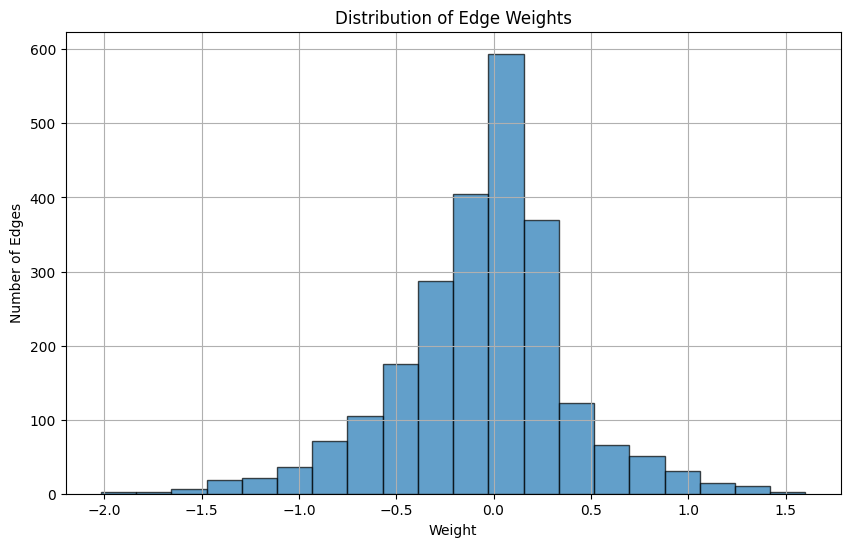

In [37]:
# Extract the 'weight' attribute values from the edges
weight_values = [data['Weight'] for _, _, data in G.edges(data=True) if 'Weight' in data]

# Plot the distribution of weight values
plt.figure(figsize=(10, 6))
plt.hist(weight_values, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Edge Weights')
plt.xlabel('Weight')
plt.ylabel('Number of Edges')
plt.grid(True)
plt.show()

Using the "handler" edge attribute, we get the edges that definitely contain one of the top-20 SHAP proteins at least

In [39]:
# subset the graph based on edge attributes
selected_edges = [(u,v) for u,v,e in G.edges(data=True) if e['handler'] == 'get']
print (selected_edges)

[('AGE/RAGE pathway WP2324', 'JUN'), ('AGE/RAGE pathway WP2324', 'MAPK9'), ('JUN', 'Apoptosis'), ('JUN', 'Apoptosis Modulation and Signaling WP1772'), ('JUN', 'Apoptosis WP254'), ('JUN', 'BMP Signaling Pathway in Eyelid Development WP3927'), ('JUN', 'C-type lectin receptor signaling pathway'), ('JUN', 'Chagas disease'), ('JUN', 'Coronavirus disease'), ('JUN', 'Cytokine Signaling In Immune System R-HSA-1280215'), ('JUN', 'Epstein-Barr virus infection'), ('JUN', 'Fluid shear stress and atherosclerosis'), ('JUN', 'Hepatitis C and Hepatocellular Carcinoma WP3646'), ('JUN', 'IL-17 signaling pathway'), ('JUN', 'IL-18 signaling pathway WP4754'), ('JUN', 'Immune System R-HSA-168256'), ('JUN', 'Innate Immune System R-HSA-168249'), ('JUN', 'Kaposi sarcoma-associated herpesvirus infection'), ('JUN', 'Lipid and atherosclerosis'), ('JUN', 'MAPK signaling pathway'), ('JUN', 'Measles'), ('JUN', 'NOD-like receptor signaling pathway'), ('JUN', 'Non-alcoholic fatty liver disease'), ('JUN', 'Non-genomic 

We are getting a new smaller network H which contains the top-20 SHAP proteins and pathways

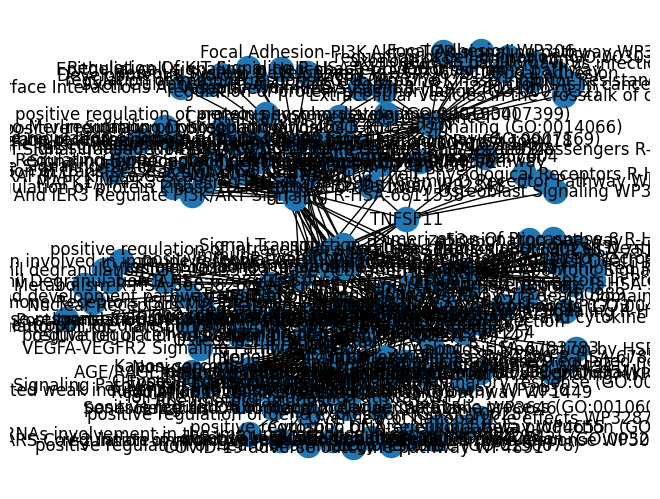

In [40]:
H = nx.Graph(((u, v, e) for u,v,e in G.edges(data=True) if e['handler'] == 'get'))
nx.draw(H,with_labels=True,node_size=300)
plt.show()

Too difficult to traverse and analyse, will try to make it more humanly tractable

In [41]:
# Step 5: Transfer node attributes
for index, row in df_node_attributes.iterrows():
    node_name = row['ID']
    if node_name in H.nodes:
        attributes = row.drop('ID')  # Remove the node name to keep only the attributes
        H.nodes[node_name].update(attributes)

In [42]:
# Sanity check 2: Inspect node attributes
node_attributes = {node: H.nodes[node] for node in H.nodes()}
node_df = pd.DataFrame(node_attributes).T

print("Node Attributes:")
print(node_df)

Node Attributes:
                                                       logFC   AveExpr  \
AGE/RAGE pathway WP2324                                  NaN       NaN   
JUN                                                 0.136524  0.173246   
MAPK9                                               0.090924  0.088538   
Apoptosis                                                NaN       NaN   
Apoptosis Modulation and Signaling WP1772                NaN       NaN   
...                                                      ...       ...   
ACAA1                                               0.076335  0.138481   
Neutrophil Degranulation R-HSA-6798695                   NaN       NaN   
neutrophil activation involved in immune respon...       NaN       NaN   
neutrophil degranulation (GO:0043312)                    NaN       NaN   
Surfactant Metabolism R-HSA-5683826                      NaN       NaN   

                                                           t   P.Value  \
AGE/RAGE pathway WP2

Here, we are filtering out the least predictive pathways based on the learning weights that are assigned as "edge weights" in the pathway-protein connections

Number of edges in the filtered subgraph: 135


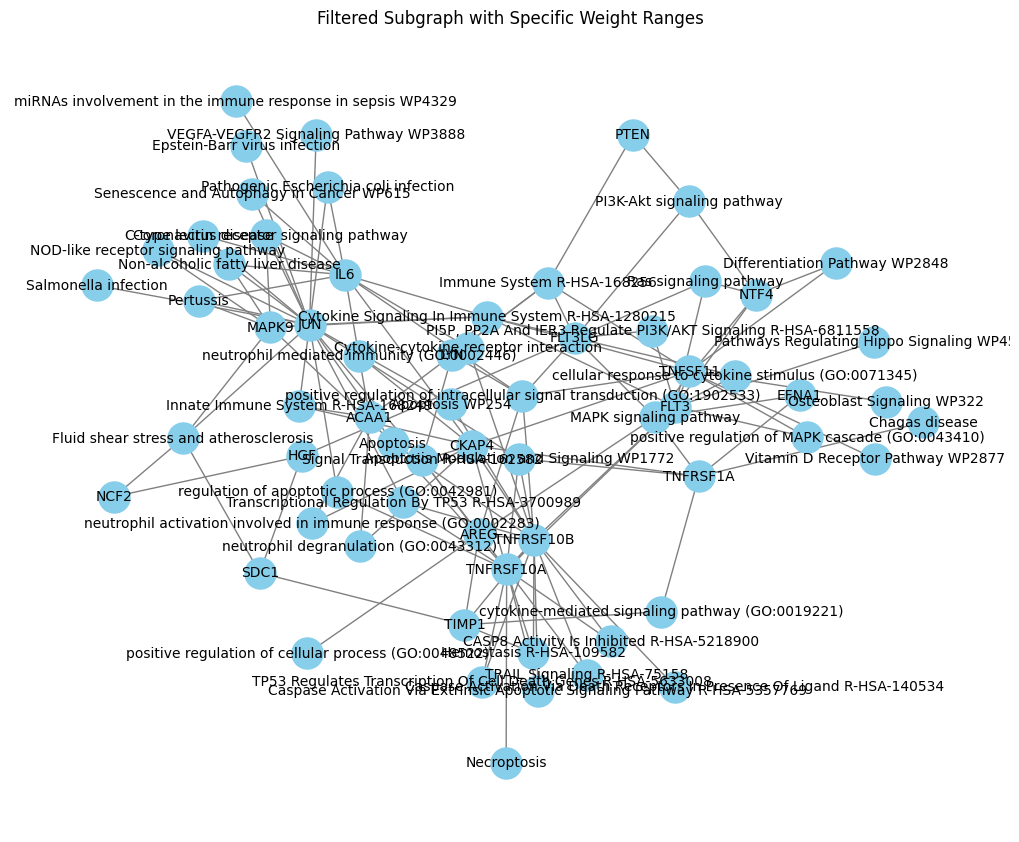

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define - arbitrarily - the cut-offs to focus on the most significant pathways based on the learning weights
lower_range = (-2, -1)
upper_range = (0.5, 1.7)

# Step 2: Filter edges based on weight ranges, including NaNs
filtered_edges = [(u, v) for u, v, data in H.edges(data=True)
                  if ('Weight' in data and
                      (np.isnan(data['Weight']) or
                       (lower_range[0] <= data['Weight'] <= lower_range[1]) or
                       (upper_range[0] <= data['Weight'] <= upper_range[1])))]

# Step 3: Create a subgraph with the filtered edges
filtered_subgraph = H.edge_subgraph(filtered_edges).copy()

# Display the filtered subgraph (optional)
print(f"Number of edges in the filtered subgraph: {len(filtered_subgraph.edges())}")

# Plot the filtered subgraph (optional)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(filtered_subgraph, seed=42)
nx.draw(filtered_subgraph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
plt.title("Filtered Subgraph with Specific Weight Ranges")
plt.show()

In [44]:
# Sanity check 1: Inspect edge attributes
edge_attributes = [{'source': source, 'target': target, **attr}
                   for source, target, attr in filtered_subgraph.edges(data=True)]

edge_df = pd.DataFrame(edge_attributes)

print("Edge Attributes:")
print(edge_df)

Edge Attributes:
                                                source  \
0                                       Chagas disease   
1                                            TNFRSF10B   
2                                            TNFRSF10B   
3                                            TNFRSF10B   
4                                            TNFRSF10B   
..                                                 ...   
130  positive regulation of intracellular signal tr...   
131  positive regulation of intracellular signal tr...   
132                                             FLT3LG   
133                                             FLT3LG   
134  Cytokine Signaling In Immune System R-HSA-1280215   

                                                target    Weight handler  \
0                                             TNFRSF1A  0.781028     get   
1                                            Apoptosis -1.579683     get   
2                                            TNFRSF10A    

In [47]:
# We are transferring the node attributes again
for index, row in df_node_attributes.iterrows():
    node_name = row['ID']
    if node_name in filtered_subgraph.nodes:
        attributes = row.drop('ID')  # Remove the node name to keep only the attributes
        filtered_subgraph.nodes[node_name].update(attributes)

In [48]:
# Sanity check 2: Inspect node attributes
node_attributes = {node: filtered_subgraph.nodes[node] for node in filtered_subgraph.nodes()}
node_df = pd.DataFrame(node_attributes).T

print("Node Attributes:")
print(node_df)

Node Attributes:
                                                       logFC   AveExpr  \
Chagas disease                                           NaN       NaN   
TNFRSF10B                                           0.124709  0.080552   
Apoptosis                                                NaN       NaN   
miRNAs involvement in the immune response in se...       NaN       NaN   
Osteoblast Signaling WP322                               NaN       NaN   
...                                                      ...       ...   
Salmonella infection                                     NaN       NaN   
neutrophil mediated immunity (GO:0002446)                NaN       NaN   
SDC1                                                0.050473 -0.001183   
Differentiation Pathway WP2848                           NaN       NaN   
LYN                                                -0.172419  0.878118   

                                                           t   P.Value  \
Chagas disease      

Here, we are going to calculate betweenness centrality using WormNet v.3-GS

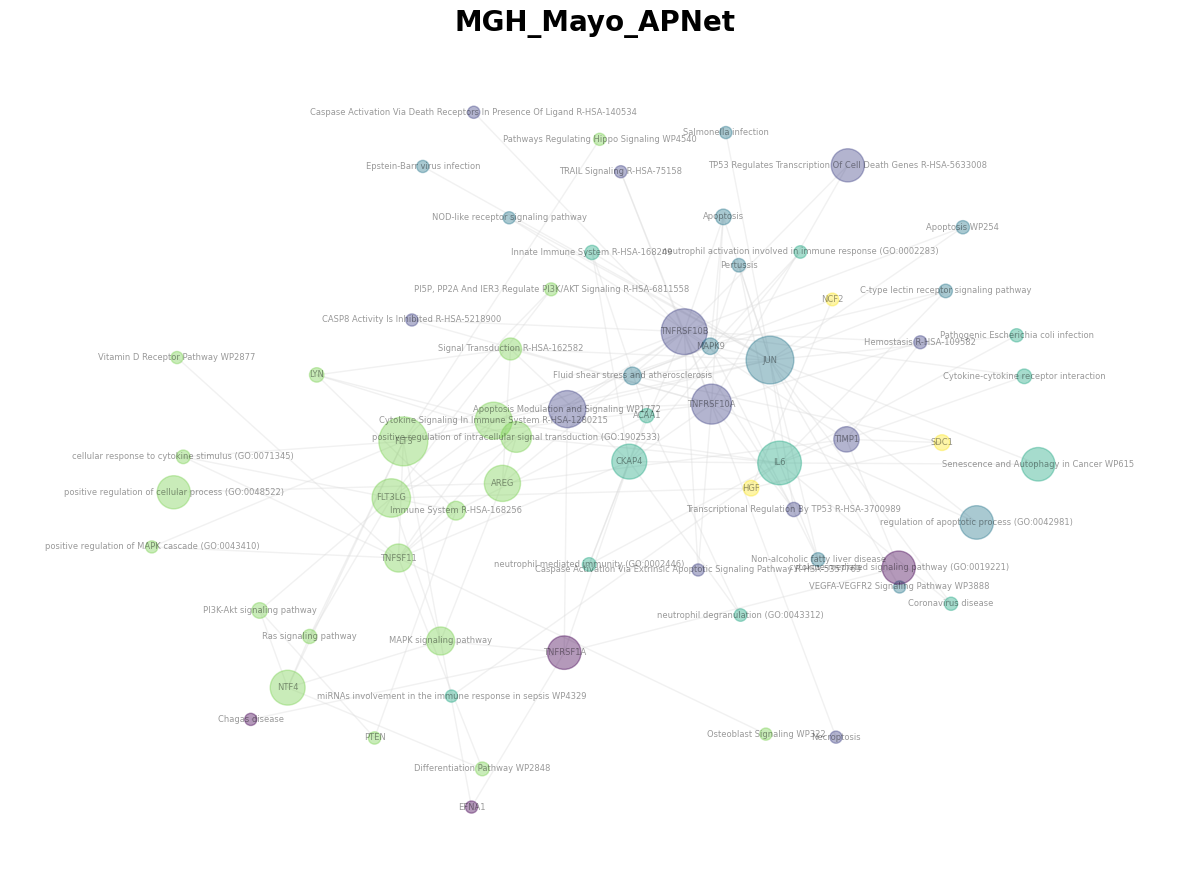

In [49]:
# Degree-centrality
# largest connected component
F = filtered_subgraph
components = nx.connected_components(F)
largest_component = max(components, key=len)
F = F.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(F, k=10, endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(F)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(12, 9))
pos = nx.spring_layout(F, k=0.7, seed=4572321)
node_color = [community_index[n] for n in F]
node_size = [v * 5000 for v in centrality.values()]
nx.draw_networkx(
    F,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
    font_size = 6
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("MGH_Mayo_APNet", font)
# Change font color for legend
font["color"] = "r"

# ax.text(
#     0.80,
#     0.10,
#     "node color = community structure",
#     horizontalalignment="center",
#     transform=ax.transAxes,
#     fontdict=font,
# )
# ax.text(
#     0.80,
#     0.06,
#     "node size = betweenness centrality",
#     horizontalalignment="center",
#     transform=ax.transAxes,
#     fontdict=font,
# )

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

In [ ]:
df_communities

Node  Community
0   cellular response to cytokine stimulus (GO:007...          0
1                              MAPK signaling pathway          0
2                                               EFNA1          0
3                      Differentiation Pathway WP2848          0
4                                                FLT3          0
..                                                ...        ...
61                                            TNFSF11          4
62   positive regulation of MAPK cascade (GO:0043410)          4
63                                                LYN          4
64                         Osteoblast Signaling WP322          4
65                  Vitamin D Receptor Pathway WP2877          4

[66 rows x 2 columns]

In [ ]:
df_communities.to_csv('node_community_mapping_APNet_MGH_Mayo.csv', index=False)

Here, we are focusing only on the top-20 SHAP protein connections and we are depicting the MI as edge weight which reflects regulatory robustness of a driver towards its target molecule(s)

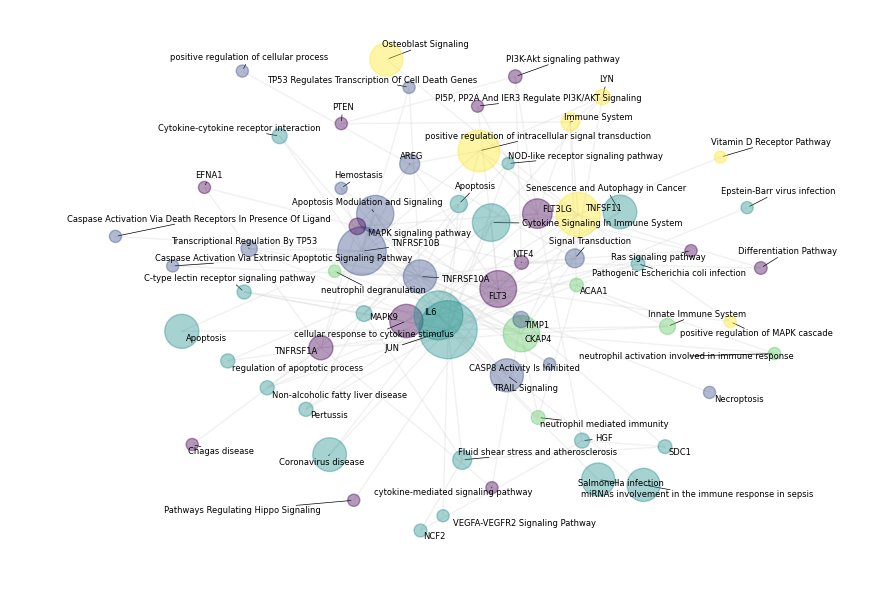

In [ ]:
# Function to clean node labels by removing specified patterns
def clean_label(label):
    # Patterns to be removed: R-HSA-XXXXX, WPXXXX, and (GO:XXXXXXX)
    patterns = [r'R-HSA-\d+', r'WP\d+', r'\(GO:\d+\)']
    for pattern in patterns:
        label = re.sub(pattern, '', label)
    return label.strip()

# Assuming F is your graph
# Assuming community_index and centrality are already computed

# Create a dictionary of cleaned labels
cleaned_labels = {node: clean_label(node) for node in F.nodes()}

# Compute positions for the nodes using spring layout with adjusted k parameter
pos = nx.spring_layout(F, k=0.7, seed=4572321)  # Increase k to spread nodes further apart

# Create the figure with adjusted size
fig, ax = plt.subplots(figsize=(9, 6))  # Increase figure size for more space

# Define node colors and sizes
node_color = [community_index[n] for n in F]
node_size = [v * 5000 for v in centrality.values()]  # Reduce node size scaling

# Draw the network graph without labels
nx.draw_networkx_nodes(
    F,
    pos=pos,
    node_color=node_color,
    node_size=node_size,
    alpha=0.4
)
nx.draw_networkx_edges(
    F,
    pos=pos,
    edge_color="gainsboro",
    alpha=0.4
)

# Collect text objects for adjust_text
texts = []
for node, label in cleaned_labels.items():
    x, y = pos[node]
    text = ax.text(x, y, label, fontsize=6, ha='center', va='center')
    texts.append(text)

# Adjust text to minimize overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# Adjust layout and remove axis
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")

# Save the figure as SVG
plt.savefig('graph_test.png', format='png', dpi=300)
plt.show()

## Capturing predictive SJARACNe subgraps

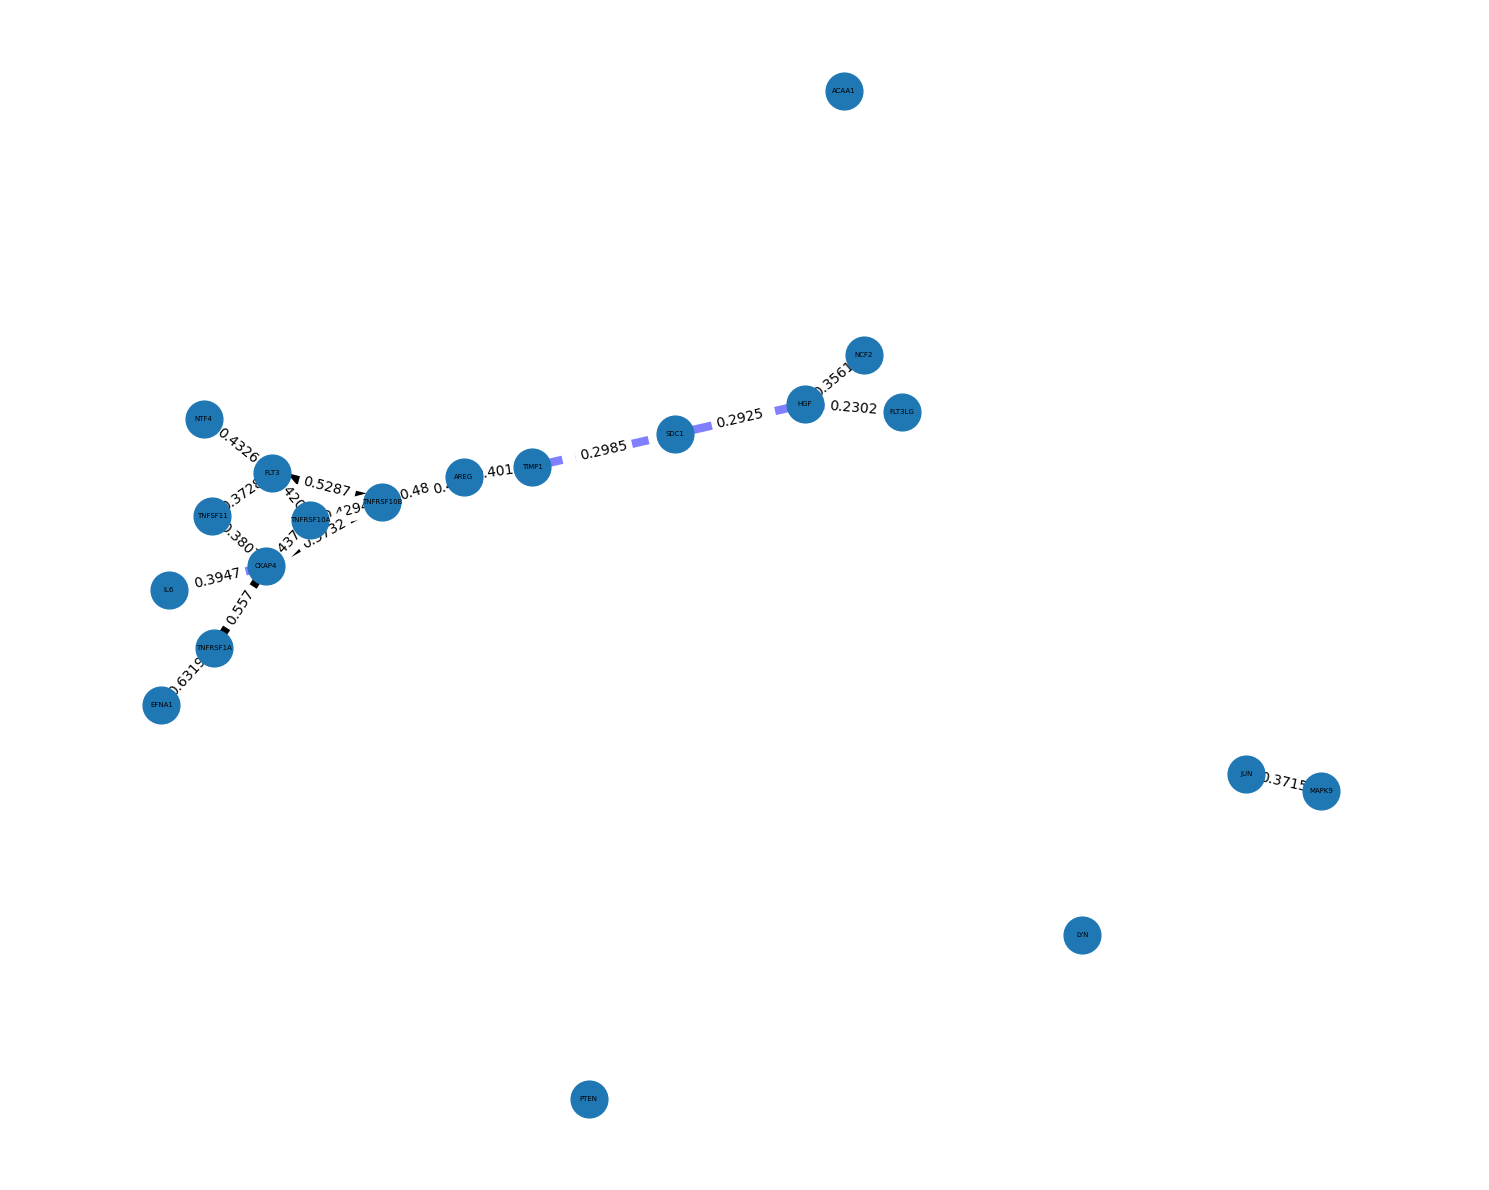

In [52]:
# # Filter based on node attribute "type" for proteins
# protein_nodes = [node for node, attr in filtered_subgraph.nodes(data=True) if attr.get('type') == 'proteins']
# # Create a subgraph with these nodes
# protein_subgraph = filtered_subgraph.subgraph(protein_nodes)
# S = protein_subgraph

# # Extract everything as graphml for Cytoscape users...

# elarge = [(u, v) for (u, v, d) in S.edges(data=True) if d["MI"] > 0.5]
# esmall = [(u, v) for (u, v, d) in S.edges(data=True) if d["MI"] <= 0.5]

# pos = nx.spring_layout(S, seed=7)  # positions for all nodes - seed for reproducibility

# plt.figure(figsize=(15, 12))  # Set the figure size

# # nodes
# nx.draw_networkx_nodes(S, pos, node_size=700)

# # edges
# nx.draw_networkx_edges(S, pos, edgelist=elarge, width=6)
# nx.draw_networkx_edges(
#     S, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
# )

# # node labels
# nx.draw_networkx_labels(S, pos, font_size=5, font_family="sans-serif")
# # edge weight labels
# edge_labels = nx.get_edge_attributes(S, "MI")
# nx.draw_networkx_edge_labels(S, pos, edge_labels)

# ax = plt.gca()
# ax.margins(0.08)
# plt.axis("off")
# plt.tight_layout()
# plt.show()

Focusing on the top-20 SHAP proteins, let's try to color them based on their logFC from based on the differential activity analysis from NetBID2. We will also highlight their connections based on the MI edge weight metric.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
<ipython-input-53-08ba7aab6ba3>:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar_nodes = plt.colorbar(sm_nodes, shrink=0.7)  # Adjust the shrink parameter to change the size
<ipython-input-53-08ba7aab6ba3>:63: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar_edges = plt.colorbar(sm_edges, shrink=0.7)  # Adjust the shrink param

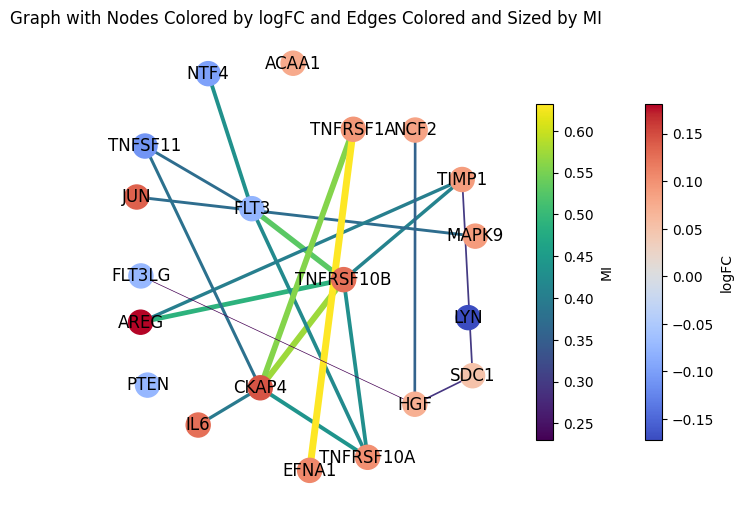

In [53]:
import networkx as nx
import matplotlib.pyplot as plt

# Filter based on node attribute "type" for proteins
protein_nodes = [node for node, attr in filtered_subgraph.nodes(data=True) if attr.get('type') == 'proteins']
# Create a subgraph with these nodes
protein_subgraph = filtered_subgraph.subgraph(protein_nodes)
S = protein_subgraph


# Extract 'logFC' values from node attributes
logFC_values = [data['logFC'] for _, data in S.nodes(data=True)]

# Normalize 'logFC' values to the range [0, 1]
# min_logFC = min(logFC_values)
# max_logFC = max(logFC_values)
# norm_logFC = [(x - min_logFC) / (max_logFC - min_logFC) for x in logFC_values]

# Choose a colormap
cmap_nodes = plt.cm.coolwarm
vmin_nodes = min(logFC_values)
vmax_nodes = max(logFC_values)
norm_nodes = plt.Normalize(vmin=vmin_nodes, vmax=vmax_nodes)

# Extract 'MI' values from edge attributes
MI_values = [data['MI'] for _, _, data in S.edges(data=True)]

# Normalize 'MI' values to the range [0, 1]
vmin_edges = min(MI_values)
vmax_edges = max(MI_values)
norm_edges = plt.Normalize(vmin=vmin_edges, vmax=vmax_edges)

# Choose a colormap for edges
cmap_edges = plt.cm.viridis

# Define a function to scale edge widths
def scale_edge_width(MI_value, min_width=0.5, max_width=5.0):
    return min_width + (max_width - min_width) * norm_edges(MI_value)

# Calculate edge widths
edge_widths = [scale_edge_width(data['MI']) for _, _, data in S.edges(data=True)]

# Draw the network with a more open layout
pos = nx.spring_layout(S, k=2)

# Draw the graph with node colors based on 'logFC' values and edge colors based on 'MI' values
nx.draw(S, pos, with_labels=True,
        node_color=[cmap_nodes(norm_nodes(logFC)) for logFC in logFC_values],
        cmap=cmap_nodes,
        edge_color=[cmap_edges(norm_edges(data['MI'])) for _, _, data in S.edges(data=True)],
        edge_cmap=cmap_edges,
        width=edge_widths)  # Set edge widths

# Add a colorbar for nodes to show the mapping of logFC values to colors
sm_nodes = plt.cm.ScalarMappable(cmap=cmap_nodes, norm=norm_nodes)
sm_nodes.set_array([])
cbar_nodes = plt.colorbar(sm_nodes, shrink=0.7)  # Adjust the shrink parameter to change the size
cbar_nodes.set_label('logFC')

# Add a colorbar for edges to show the mapping of MI values to colors
sm_edges = plt.cm.ScalarMappable(cmap=cmap_edges, norm=norm_edges)
sm_edges.set_array([])
cbar_edges = plt.colorbar(sm_edges, shrink=0.7)  # Adjust the shrink parameter to change the size
cbar_edges.set_label('MI')

plt.title("Graph with Nodes Colored by logFC and Edges Colored and Sized by MI")
plt.savefig('top_20_SHAP_MGH_Mayo_SJARACNe.png', format='png', dpi=300)
plt.show()

Below a visualisation for the largest connected component

Degree Centrality: {'TNFRSF10A': 0.21428571428571427, 'TIMP1': 0.21428571428571427, 'IL6': 0.07142857142857142, 'TNFSF11': 0.14285714285714285, 'EFNA1': 0.07142857142857142, 'FLT3': 0.2857142857142857, 'NTF4': 0.07142857142857142, 'TNFRSF1A': 0.14285714285714285, 'CKAP4': 0.3571428571428571, 'TNFRSF10B': 0.3571428571428571, 'HGF': 0.21428571428571427, 'NCF2': 0.07142857142857142, 'SDC1': 0.14285714285714285, 'AREG': 0.14285714285714285, 'FLT3LG': 0.07142857142857142}
Betweenness Centrality: {'TNFRSF10A': 0.02930402930402931, 'TIMP1': 0.4395604395604396, 'IL6': 0.0, 'TNFSF11': 0.02930402930402931, 'EFNA1': 0.0, 'FLT3': 0.18681318681318682, 'NTF4': 0.0, 'TNFRSF1A': 0.14285714285714288, 'CKAP4': 0.4285714285714286, 'TNFRSF10B': 0.5567765567765569, 'HGF': 0.27472527472527475, 'NCF2': 0.0, 'SDC1': 0.3626373626373627, 'AREG': 0.0, 'FLT3LG': 0.0}
Clustering Coefficient: {'TNFRSF10A': 0.6666666666666666, 'TIMP1': 0.3333333333333333, 'IL6': 0, 'TNFSF11': 0, 'EFNA1': 0, 'FLT3': 0.166666666666666

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
<ipython-input-39-e8e660d4a563>:76: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar_nodes = plt.colorbar(sm_nodes, shrink=0.7)  # Adjust the shrink parameter to change the size
<ipython-input-39-e8e660d4a563>:82: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar_edges = plt.colorbar(sm_edges, shrink=0.7)  # Adjust the shrink param

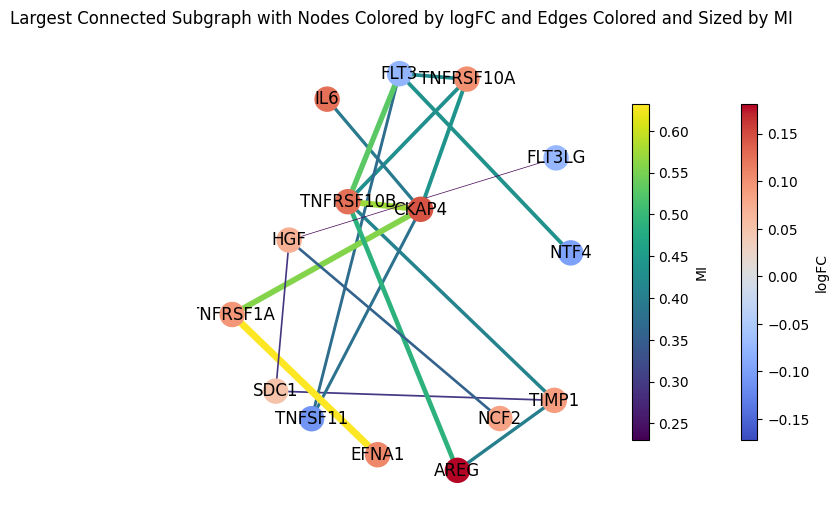

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Extract 'logFC' values from node attributes
logFC_values = [data['logFC'] for _, data in S.nodes(data=True)]

# Normalize 'logFC' values to the range [0, 1]
vmin_nodes = min(logFC_values)
vmax_nodes = max(logFC_values)
norm_nodes = plt.Normalize(vmin=vmin_nodes, vmax=vmax_nodes)

# Extract 'MI' values from edge attributes
MI_values = [data['MI'] for _, _, data in S.edges(data=True)]

# Normalize 'MI' values to the range [0, 1]
vmin_edges = min(MI_values)
vmax_edges = max(MI_values)
norm_edges = plt.Normalize(vmin=vmin_edges, vmax=vmax_edges)

# Choose a colormap for nodes and edges
cmap_nodes = plt.cm.coolwarm
cmap_edges = plt.cm.viridis

# Define a function to scale edge widths
def scale_edge_width(MI_value, min_width=0.5, max_width=5.0):
    return min_width + (max_width - min_width) * norm_edges(MI_value)

# Calculate edge widths
edge_widths = [scale_edge_width(data['MI']) for _, _, data in S.edges(data=True)]

# Find all connected subgraphs
connected_subgraphs = list(nx.connected_components(S))

# Select the largest connected subgraph
largest_subgraph = max(connected_subgraphs, key=len)

# Create a subgraph from the largest connected component
S_largest = S.subgraph(largest_subgraph).copy()

# Calculate network metrics for the largest connected subgraph
degree_centrality = nx.degree_centrality(S_largest)
betweenness_centrality = nx.betweenness_centrality(S_largest)
clustering_coefficient = nx.clustering(S_largest)

# Calculate additional network metrics
average_shortest_path_length = nx.average_shortest_path_length(S_largest)
diameter = nx.diameter(S_largest)
density = nx.density(S_largest)

# Print or analyze the metrics
print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Clustering Coefficient:", clustering_coefficient)
print("Average Shortest Path Length:", average_shortest_path_length)
print("Diameter:", diameter)
print("Density:", density)

# Extract 'logFC' values for the largest subgraph
logFC_values_largest = [data['logFC'] for _, data in S_largest.nodes(data=True)]

# Draw the network with a more open layout for the largest subgraph
pos = nx.spring_layout(S_largest, k=2.2)

# Draw the graph with node colors based on 'logFC' values and edge colors based on 'MI' values
nx.draw(S_largest, pos, with_labels=True,
        node_color=[cmap_nodes(norm_nodes(logFC)) for logFC in logFC_values_largest],
        cmap=cmap_nodes,
        edge_color=[cmap_edges(norm_edges(data['MI'])) for _, _, data in S_largest.edges(data=True)],
        edge_cmap=cmap_edges,
        width=[scale_edge_width(data['MI']) for _, _, data in S_largest.edges(data=True)])  # Set edge widths

# Add a colorbar for nodes to show the mapping of logFC values to colors
sm_nodes = plt.cm.ScalarMappable(cmap=cmap_nodes, norm=norm_nodes)
sm_nodes.set_array([])
cbar_nodes = plt.colorbar(sm_nodes, shrink=0.7)  # Adjust the shrink parameter to change the size
cbar_nodes.set_label('logFC')

# Add a colorbar for edges to show the mapping of MI values to colors
sm_edges = plt.cm.ScalarMappable(cmap=cmap_edges, norm=norm_edges)
sm_edges.set_array([])
cbar_edges = plt.colorbar(sm_edges, shrink=0.7)  # Adjust the shrink parameter to change the size
cbar_edges.set_label('MI')

plt.title("Largest Connected Subgraph with Nodes Colored by logFC and Edges Colored and Sized by MI")
plt.savefig('largest_connected_subgraph.png', format='png', dpi=300)
plt.show()

# **Connecting ACAA1 with other predictive drivers through shortest paths**

It is obvious that the top-20 most predictive proteins are mostly interconnected through SJARACNe regulatory connections (MI highlighted as edge weight) which points towards the underlying biology driving severe COVID-19. However, some of the most predictive proteins are not connected which may indicate important intermediate protein-nodes that need to be retrieved and that could potentially be of translational interest.

Let's find directionality for regulation among the top-20 drivers

Bayesian inference of regulatory networks involves using Bayesian methods to model and infer the relationships and interactions between proteins within a regulatory network. This approach allows for the incorporation of prior knowledge and the quantification of uncertainty in the predictions. Since we have deployed NetBID2 in plasma proteomics and not in RNA-seq which is its native premise, this step is necessary to infer directionality in the regulatory networks retrieved. Otherwise, NetBID2 uses prior knowledge to designate TFs and drivers and always considers them the sources of potential regulons. Here, since plasma proteins are all potentially signal-prone, we use Baysian inference to find possible regulatory connections through directed graphs.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  0%|          | 0/1000000 [00:00<?, ?it/s]

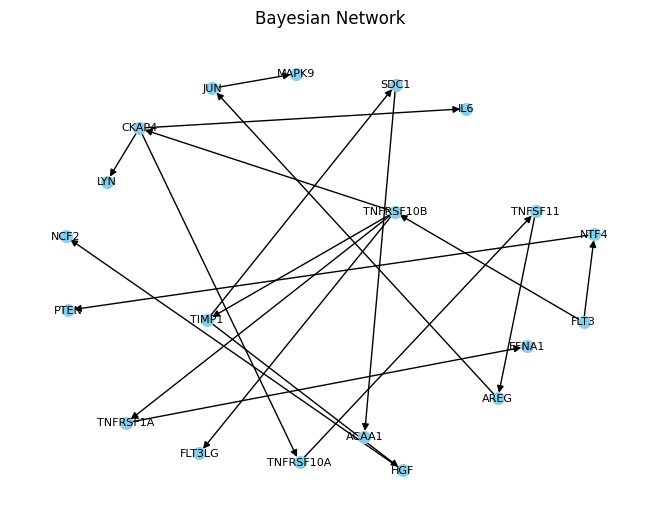

In [68]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator
from pgmpy.models import BayesianNetwork
import networkx as nx
import matplotlib.pyplot as plt

# Load and prepare the data
df = pd.read_csv("MGH_activity_matrix/activity_matrix.csv", index_col=0)
df = df.T
df_filtered = df.loc[:, SHAP_proteins]

# Binning continuous variables
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
data_discretized = pd.DataFrame(est.fit_transform(df_filtered), columns=df_filtered.columns)

# Structure learning
hc = HillClimbSearch(data_discretized)
best_model = hc.estimate(scoring_method=BicScore(data_discretized))

# Convert the learned DAG to a BayesianNetwork
model = BayesianNetwork(best_model.edges())

# Estimate the CPDs using MaximumLikelihoodEstimator
model.fit(data_discretized, estimator=BayesianEstimator)

# Plotting the network
def plot_bayesian_network(model):
    # Create a directed graph using networkx
    G = nx.DiGraph()
    G.add_edges_from(model.edges())

    # Draw the graph
    pos = nx.spring_layout(G, k=2)
    nx.draw(G, pos, with_labels=True, node_size=70, node_color="skyblue", font_size=8, arrowsize=10)
    plt.title("Bayesian Network")
    plt.savefig('Bayesian_APNet_MGH_Mayo.png', format='png', dpi=300)
    plt.show()

# Call the plotting function
plot_bayesian_network(model)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  0%|          | 0/1000000 [00:00<?, ?it/s]

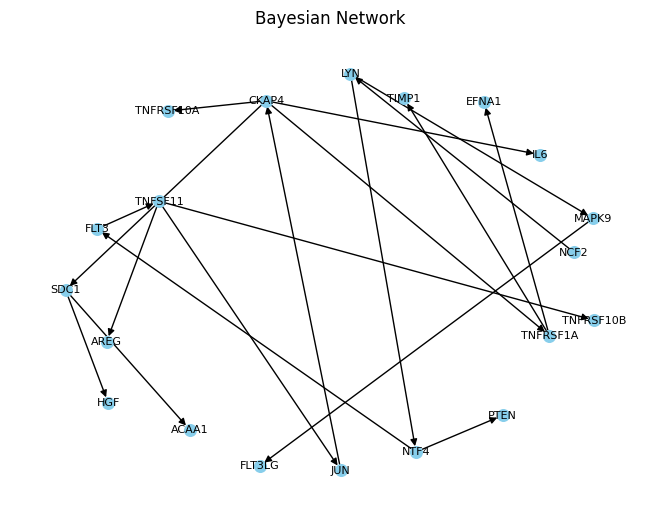

In [69]:
df = pd.read_csv("Mayo_activity_matrix/activity_matrix.csv", index_col=0)
df = df.T

df_filtered = df.loc[:, SHAP_proteins]

# Binning continuous variables (optional step)
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
data_discretized = pd.DataFrame(est.fit_transform(df_filtered), columns=df_filtered.columns)

# Structure learning
hc = HillClimbSearch(data_discretized)
best_model = hc.estimate(scoring_method=BicScore(data_discretized))

# Convert the learned DAG to a BayesianNetwork
model = BayesianNetwork(best_model.edges())

# Estimate the CPDs using MaximumLikelihoodEstimator
model.fit(data_discretized, estimator=BayesianEstimator)

# Plotting the network
def plot_bayesian_network(model):
    # Create a directed graph using networkx
    G = nx.DiGraph()
    G.add_edges_from(model.edges())

    # Draw the graph
    pos = nx.spring_layout(G, k=2)
    nx.draw(G, pos, with_labels=True, node_size=70, node_color="skyblue", font_size=8, arrowsize=10)
    plt.title("Bayesian Network")
    plt.savefig('Bayesian_APNet_Mayo.png', format='png', dpi=300)
    plt.show()

# Call the plotting function
plot_bayesian_network(model)

Based on the above we will seek connections among SDC1 and ACAA1

In [55]:
# Isolate from original G, only protein-nodes and not pathway nodes
protein_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'proteins']
protein_subgraph = G.subgraph(protein_nodes)

In [63]:
#Sanity check
# Sanity check 2: Inspect node attributes
node_attributes = {node: protein_subgraph.nodes[node] for node in protein_subgraph.nodes()}
node_df = pd.DataFrame(node_attributes).T

print("Node Attributes:")
print(node_df)

Node Attributes:
              logFC   AveExpr         t   P.Value adj.P.Val Z-statistics  \
CASP8      0.057452  0.142097  3.576592  0.000405  0.000938     3.536773   
EZR        0.094855  0.155731  7.908479       0.0       0.0     7.534379   
JUN        0.136524  0.173246  9.268112       0.0       0.0     8.689181   
MAPK9      0.090924  0.088538  9.231139       0.0       0.0     8.658484   
MSR1       0.013489  0.040934  3.293126  0.001108  0.002315     3.261534   
...             ...       ...       ...       ...       ...          ...   
THBD       0.050785 -0.111856   3.36571  0.000862  0.001854     3.332132   
VSTM2L    -0.041275  0.081159 -5.121871  0.000001  0.000003    -5.011815   
TXNDC5     0.040998 -0.021577  2.903807  0.003957  0.007472      2.88153   
TNFRSF11A  0.096193 -0.273429  2.662659  0.008167  0.014321     2.645099   
ULBP2      0.154291 -0.008186  4.106495  0.000052  0.000144     4.047694   

          Ave.NonSevere Ave.Severe Top20ShapDriver_or_pathway      typ

In [57]:
# Sanity check 1: Inspect edge attributes
edge_attributes = [{'source': source, 'target': target, **attr}
                   for source, target, attr in protein_subgraph.edges(data=True)]

edge_df = pd.DataFrame(edge_attributes)

print("Edge Attributes:")
print(edge_df)

Edge Attributes:
      source   target  Weight handler      MI  spearman  p-value
0      CASP8    APEX1     NaN    None  0.3739    0.5114      0.0
1      CASP8    GLOD4     NaN    None  0.5803    0.6670      0.0
2      CASP8     HMBS     NaN    None  0.4645    0.5602      0.0
3      CASP8     NUB1     NaN    None  0.3637    0.3979      0.0
4      CASP8    NUDT5     NaN    None  0.4475    0.6179      0.0
...      ...      ...     ...     ...     ...       ...      ...
3767  ZBTB17    PPCDC     NaN    None  0.3883    0.4894      0.0
3768  ZBTB17   SETMAR     NaN    None  0.3359    0.4681      0.0
3769  ZBTB17  TNFRSF8     NaN    None  0.2527    0.4038      0.0
3770  ZBTB17   TXNRD1     NaN    None  0.3885    0.5042      0.0
3771  ZBTB17     WARS     NaN    None  0.3829    0.5838      0.0

[3772 rows x 7 columns]


We will be looking for all potential connections of ACAA1 and the other 19 most predictive proteins, to uncover more proteins of potential interest and biological relevance

Shortest path from SDC1 to ACAA1: ['SDC1', 'LDLR', 'VWF', 'PTPRS', 'ACAA1']


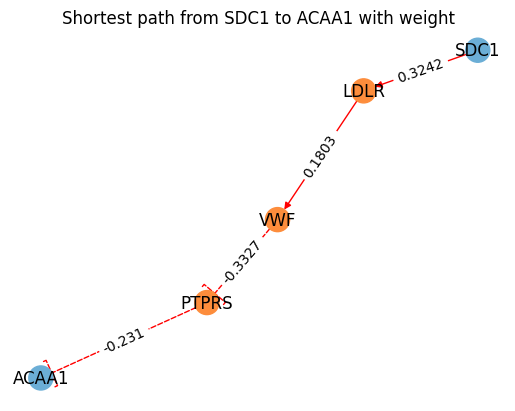

All shortest paths: [['SDC1', 'LDLR', 'VWF', 'PTPRS', 'ACAA1']]


In [66]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the colors
blue_color = '#6baed6'  # Pastel blue
orange_color = '#fd8d3c'  # Burnt orange

# The start node
start_node = "SDC1"
# The target node
target_node = "ACAA1"

# Initialize the global shortest path subgraph
global_shortest_path_subgraph = nx.DiGraph()

# List to store all shortest paths
all_shortest_paths = []

# Function to add edges and nodes to the global subgraph
def add_path_to_subgraph(path):
    path_edges = list(zip(path, path[1:]))
    global_shortest_path_subgraph.add_nodes_from(path)
    global_shortest_path_subgraph.add_edges_from(path_edges)

    # Copy logFC attributes to the global subgraph
    for node in path:
        global_shortest_path_subgraph.nodes[node]['logFC'] = protein_subgraph.nodes[node]['logFC']
        global_shortest_path_subgraph.nodes[node]['Top20ShapDriver_or_pathway'] = protein_subgraph.nodes[node].get('Top20ShapDriver_or_pathway', 'no')

    # Copy MI attributes to the global subgraph
    for u, v in path_edges:
        global_shortest_path_subgraph[u][v]['MI'] = protein_subgraph[u][v]['MI']
        global_shortest_path_subgraph[u][v]['spearman'] = protein_subgraph[u][v]['spearman']

# Function to draw edges with custom styles based on 'spearman' values
def draw_custom_edges(subgraph, pos):
    for u, v, d in subgraph.edges(data=True):
        if d['spearman'] > 0:
            # Draw positive edges with arrows
            nx.draw_networkx_edges(subgraph, pos, edgelist=[(u, v)], edge_color='red', arrowstyle='-|>', arrows=True)
        else:
            # Draw negative edges with inhibition markers
            nx.draw_networkx_edges(subgraph, pos, edgelist=[(u, v)], edge_color='red', arrowstyle='-[', arrows=True, style='dashed')

try:
    # Find the shortest path
    path = nx.shortest_path(protein_subgraph, start_node, target_node, weight='MI')
    print(f"Shortest path from {start_node} to {target_node}:", path)

    # Add the path to the global subgraph
    add_path_to_subgraph(path)

    # Add the path to the list of all shortest paths
    all_shortest_paths.append(path)

    # Create a subgraph consisting only of the nodes and edges in the current shortest path
    shortest_path_subgraph = global_shortest_path_subgraph.subgraph(path).copy()

    # Extract 'shap' values from node attributes for the nodes in the current shortest path subgraph
    node_colors = [blue_color if data.get('Top20ShapDriver_or_pathway', 'no') == 'yes' else orange_color for _, data in shortest_path_subgraph.nodes(data=True)]

    # Create a list of edges in the shortest path
    path_edges = list(zip(path, path[1:]))

    # Visualize the current shortest path subgraph with node colors based on 'shap'
    pos = nx.spring_layout(shortest_path_subgraph)
    nx.draw_networkx_nodes(
        shortest_path_subgraph, pos,
        node_color=node_colors
    )
    draw_custom_edges(shortest_path_subgraph, pos)
    nx.draw_networkx_labels(shortest_path_subgraph, pos)
    nx.draw_networkx_edge_labels(
        shortest_path_subgraph, pos, edge_labels={(u, v): d["spearman"] for u, v, d in shortest_path_subgraph.edges(data=True)}
    )

    # Turn off the frame
    plt.gca().set_frame_on(False)
    plt.axis('off')

    # Set the title of the plot
    plt.title(f'Shortest path from {start_node} to {target_node} with weight')
    plt.savefig('SDC1_ACAA1_shortest_weight.png', format='png', dpi=300)
    # Show the plot
    plt.show()

except nx.NetworkXNoPath:
    print(f"No path found from {start_node} to {target_node}")

# Output the list of all shortest paths
print("All shortest paths:", all_shortest_paths)

In [ ]:
# Summary Statistics
# Number of nodes:  25
# Number of edges: 129
# Avg. number of neighbors:    6.320
# Network diameter:   4
# Network radius:   2
# Characteristic path length:    1.987
# Clustering coefficient:    0.506
# Network density:    0.263
# Network heterogeneity:    0.512
# Network centralization:    0.303
# Connected components:   1
# Analysis time (sec):    0.004

Shortest path from SDC1 to ACAA1: ['SDC1', 'KRT18', 'GRPEL1', 'ACAA1']


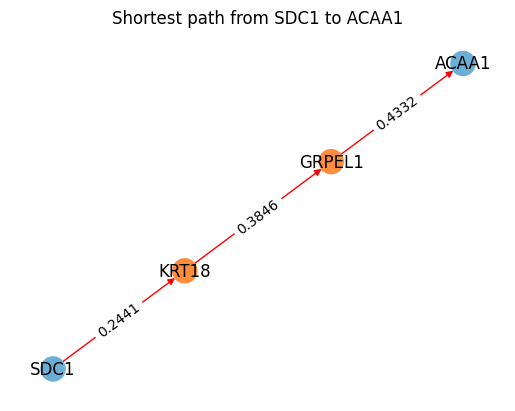

All shortest paths: [['SDC1', 'KRT18', 'GRPEL1', 'ACAA1']]


In [67]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the colors
blue_color = '#6baed6'  # Pastel blue
orange_color = '#fd8d3c'  # Burnt orange

# The start node
start_node = "SDC1"
# The target node
target_node = "ACAA1"

# Initialize the global shortest path subgraph
global_shortest_path_subgraph = nx.DiGraph()

# List to store all shortest paths
all_shortest_paths = []

# Function to add edges and nodes to the global subgraph
def add_path_to_subgraph(path):
    path_edges = list(zip(path, path[1:]))
    global_shortest_path_subgraph.add_nodes_from(path)
    global_shortest_path_subgraph.add_edges_from(path_edges)

    # Copy logFC attributes to the global subgraph
    for node in path:
        global_shortest_path_subgraph.nodes[node]['logFC'] = protein_subgraph.nodes[node]['logFC']
        global_shortest_path_subgraph.nodes[node]['Top20ShapDriver_or_pathway'] = protein_subgraph.nodes[node].get('Top20ShapDriver_or_pathway', 'no')

    # Copy MI attributes to the global subgraph
    for u, v in path_edges:
        global_shortest_path_subgraph[u][v]['MI'] = protein_subgraph[u][v]['MI']

try:
    # Find the shortest path
    path = nx.shortest_path(protein_subgraph, start_node, target_node)
    print(f"Shortest path from {start_node} to {target_node}:", path)

    # Add the path to the global subgraph
    add_path_to_subgraph(path)

    # Add the path to the list of all shortest paths
    all_shortest_paths.append(path)

    # Create a subgraph consisting only of the nodes and edges in the current shortest path
    shortest_path_subgraph = nx.DiGraph(protein_subgraph.subgraph(path).copy())

    # Extract 'shap' values from node attributes for the nodes in the current shortest path subgraph
    node_colors = [blue_color if data.get('Top20ShapDriver_or_pathway', 'no') == 'yes' else orange_color for _, data in shortest_path_subgraph.nodes(data=True)]

    # Create a list of edges in the shortest path
    path_edges = list(zip(path, path[1:]))

    # Visualize the current shortest path subgraph with node colors based on 'shap'
    pos = nx.spring_layout(shortest_path_subgraph)
    nx.draw_networkx_nodes(
        shortest_path_subgraph, pos,
        node_color=node_colors
    )
    nx.draw_networkx_edges(shortest_path_subgraph, pos, edgelist=path_edges, edge_color='red', arrows=True)
    nx.draw_networkx_labels(shortest_path_subgraph, pos)
    nx.draw_networkx_edge_labels(
        shortest_path_subgraph, pos, edge_labels={(u, v): d["MI"] for u, v, d in shortest_path_subgraph.edges(data=True)}
    )

    # Turn off the frame
    plt.gca().set_frame_on(False)
    plt.axis('off')

    # Set the title of the plot
    plt.title(f'Shortest path from {start_node} to {target_node}')
    plt.savefig('SDC1_ACAA1_shortest.png', format='png', dpi=300)
    # Show the plot
    plt.show()

except nx.NetworkXNoPath:
    print(f"No path found from {start_node} to {target_node}")

# Output the list of all shortest paths
print("All shortest paths:", all_shortest_paths)

The most prioritised shortest path for ACAA1 is the one originating from SDC1. To recap, this is happening for several reasons:


*   Bayesian directionality from SDC1 to ACAA1 predicted based on activity transformations of MGH, Mayo
*   Short size (4 nodes in total from the SJARACNe network)
*   STRINGdb independent validation that members of the path are sharing PPI connections
*   Both ACAA1 and SDC1 go through hidden node 20 when foreshadowing severe COVID-19
*   ACAA1 is predominantly a liver-associated mitochondrial protein - MAPK9 goes through hidden node 20 through a liver-connected pathway (both top-20 SHAP proteins)









## ACAA1 neighborhouds

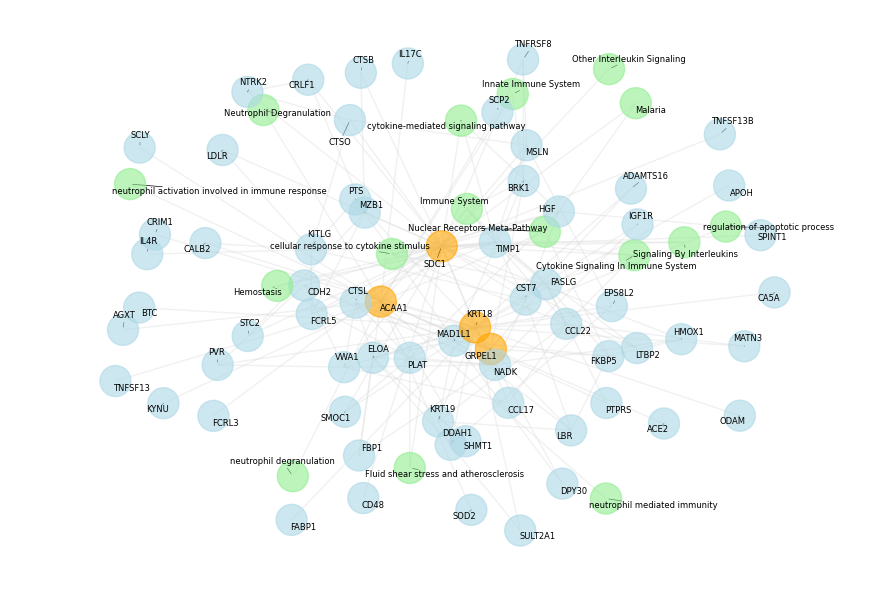

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredOffsetbox
from matplotlib.offsetbox import TextArea, VPacker
import re

# Function to clean node labels by removing specified patterns
def clean_label(label):
    # Patterns to be removed: R-HSA-XXXXX, WPXXXX, and (GO:XXXXXXX)
    patterns = [r'R-HSA-\d+', r'WP\d+', r'\(GO:\d+\)']
    for pattern in patterns:
        label = re.sub(pattern, '', label)
    return label.strip()

# List of specified seed nodes
seed_nodes = ['SDC1', 'GRPEL1', 'KRT18', 'ACAA1']

# Initialize a set to store the nodes in the subgraph
subgraph_nodes = set(seed_nodes)

# Add immediate neighbors of the seed nodes to the set
for node in seed_nodes:
    subgraph_nodes.update(G.neighbors(node))

# Create the subgraph
subgraph = G.subgraph(subgraph_nodes).copy()

# Clean node labels for pathways
cleaned_labels = {}
for node, data in subgraph.nodes(data=True):
    if data.get('type') == 'pathway':
        cleaned_labels[node] = clean_label(node)
    else:
        cleaned_labels[node] = node

# Compute positions for the nodes using spring layout with adjusted k parameter
pos = nx.spring_layout(subgraph, k=0.7, seed=4572321)  # Increase k to spread nodes further apart

# Determine node colors based on attributes
node_colors = []
for node in subgraph.nodes(data=True):
    if node[1].get('type') == 'pathway':
        node_colors.append('lightgreen')
    elif node[0] in ['SDC1', 'KRT18', 'GRPEL1', 'ACAA1']:
        node_colors.append('orange')
    else:
        node_colors.append('lightblue')  # Default color

# Create the figure with adjusted size
fig, ax = plt.subplots(figsize=(9, 6))  # Increase figure size for more space

# Draw the network graph without labels
nx.draw_networkx_nodes(
    subgraph,
    pos=pos,
    node_color=node_colors,
    node_size=500,
    alpha=0.6,
    ax=ax
)
nx.draw_networkx_edges(
    subgraph,
    pos=pos,
    edge_color="gainsboro",
    alpha=0.4,
    ax=ax
)

# Collect text objects for adjust_text
texts = []
for node, label in cleaned_labels.items():
    x, y = pos[node]
    text = ax.text(x, y, label, fontsize=6, ha='center', va='center')
    texts.append(text)

# Adjust text to minimize overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# # Add legend with colored phrases at the bottom right corner
# green_text = TextArea("Pathways", textprops=dict(color='green', fontsize=8))
# orange_text = TextArea("Seed Protein Nodes", textprops=dict(color='orange', fontsize=8))
# blue_text = TextArea("Other Proteins", textprops=dict(color='lightblue', fontsize=8))

# # Combine the colored text phrases
# legend_box = VPacker(children=[green_text, orange_text, blue_text], align="left", pad=0, sep=5)

# # Place the legend on the plot
# anchored_box = AnchoredOffsetbox(loc='lower right', child=legend_box, frameon=False, bbox_to_anchor=(1.05, -0.05),
#                                  bbox_transform=ax.transAxes, borderpad=0.5)
# ax.add_artist(anchored_box)

# Adjust layout and remove axis
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")

# Save the figure as PNG
plt.savefig('ACAA1_SDC1_short_neighb.png', format='png', dpi=300)
plt.show()

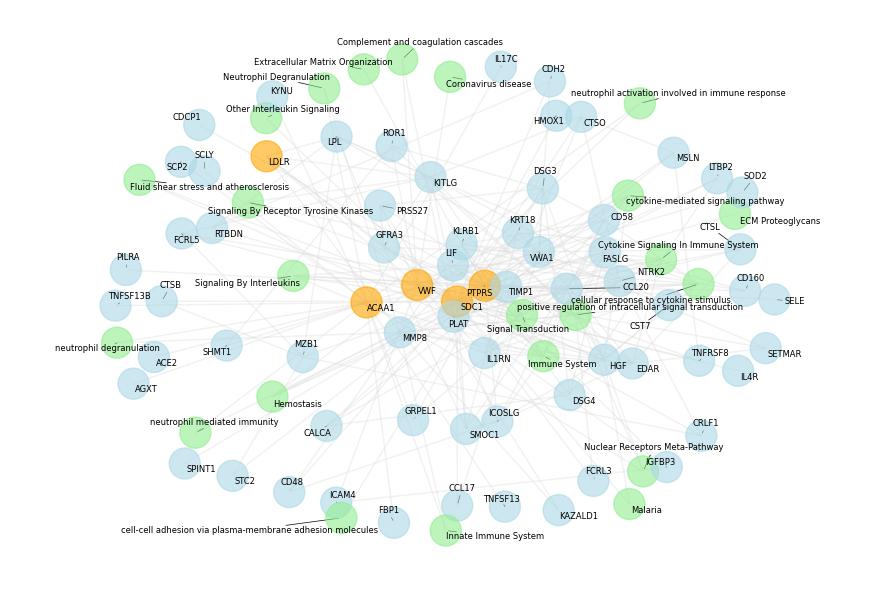

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredOffsetbox
from matplotlib.offsetbox import TextArea, VPacker
import re

# Function to clean node labels by removing specified patterns
def clean_label(label):
    # Patterns to be removed: R-HSA-XXXXX, WPXXXX, and (GO:XXXXXXX)
    patterns = [r'R-HSA-\d+', r'WP\d+', r'\(GO:\d+\)']
    for pattern in patterns:
        label = re.sub(pattern, '', label)
    return label.strip()

# List of specified seed nodes
seed_nodes = ['SDC1', 'LDLR', 'VWF', 'PTPRS', 'ACAA1']

# Initialize a set to store the nodes in the subgraph
subgraph_nodes = set(seed_nodes)

# Add immediate neighbors of the seed nodes to the set
for node in seed_nodes:
    subgraph_nodes.update(G.neighbors(node))

# Create the subgraph
subgraph = G.subgraph(subgraph_nodes).copy()

# Clean node labels for pathways
cleaned_labels = {}
for node, data in subgraph.nodes(data=True):
    if data.get('type') == 'pathway':
        cleaned_labels[node] = clean_label(node)
    else:
        cleaned_labels[node] = node

# Compute positions for the nodes using spring layout with adjusted k parameter
pos = nx.spring_layout(subgraph, k=1.0, seed=4572321)  # Increase k to spread nodes further apart

# Determine node colors based on attributes
node_colors = []
for node in subgraph.nodes(data=True):
    if node[1].get('type') == 'pathway':
        node_colors.append('lightgreen')
    elif node[0] in ['SDC1', 'LDLR', 'VWF', 'PTPRS', 'ACAA1']:
        node_colors.append('orange')
    else:
        node_colors.append('lightblue')  # Default color

# Create the figure with adjusted size
fig, ax = plt.subplots(figsize=(9, 6))  # Increase figure size for more space

# Draw the network graph without labels
nx.draw_networkx_nodes(
    subgraph,
    pos=pos,
    node_color=node_colors,
    node_size=500,
    alpha=0.6,
    ax=ax
)
nx.draw_networkx_edges(
    subgraph,
    pos=pos,
    edge_color="gainsboro",
    alpha=0.4,
    ax=ax
)

# Collect text objects for adjust_text
texts = []
for node, label in cleaned_labels.items():
    x, y = pos[node]
    text = ax.text(x, y, label, fontsize=6, ha='center', va='center')
    texts.append(text)

# Adjust text to minimize overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# # Add legend with colored phrases at the bottom right corner
# green_text = TextArea("Pathways", textprops=dict(color='green', fontsize=8))
# orange_text = TextArea("Seed Protein Nodes", textprops=dict(color='orange', fontsize=8))
# blue_text = TextArea("Other Proteins", textprops=dict(color='lightblue', fontsize=8))

# # Combine the colored text phrases
# legend_box = VPacker(children=[green_text, orange_text, blue_text], align="left", pad=0, sep=5)

# # Place the legend on the plot
# anchored_box = AnchoredOffsetbox(loc='lower right', child=legend_box, frameon=False, bbox_to_anchor=(1.05, -0.05),
#                                  bbox_transform=ax.transAxes, borderpad=0.5)
# ax.add_artist(anchored_box)

# Adjust layout and remove axis
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")

# Save the figure as PNG
plt.savefig('ACAA1_SDC1_extend_neighb.png', format='png', dpi=300)
plt.show()

# Multi-panel figures

## Figure 4

To assemble Figure 4 we need the heatmaps with Pearson correlation calculated in the Clinical_biological_explainability notebook

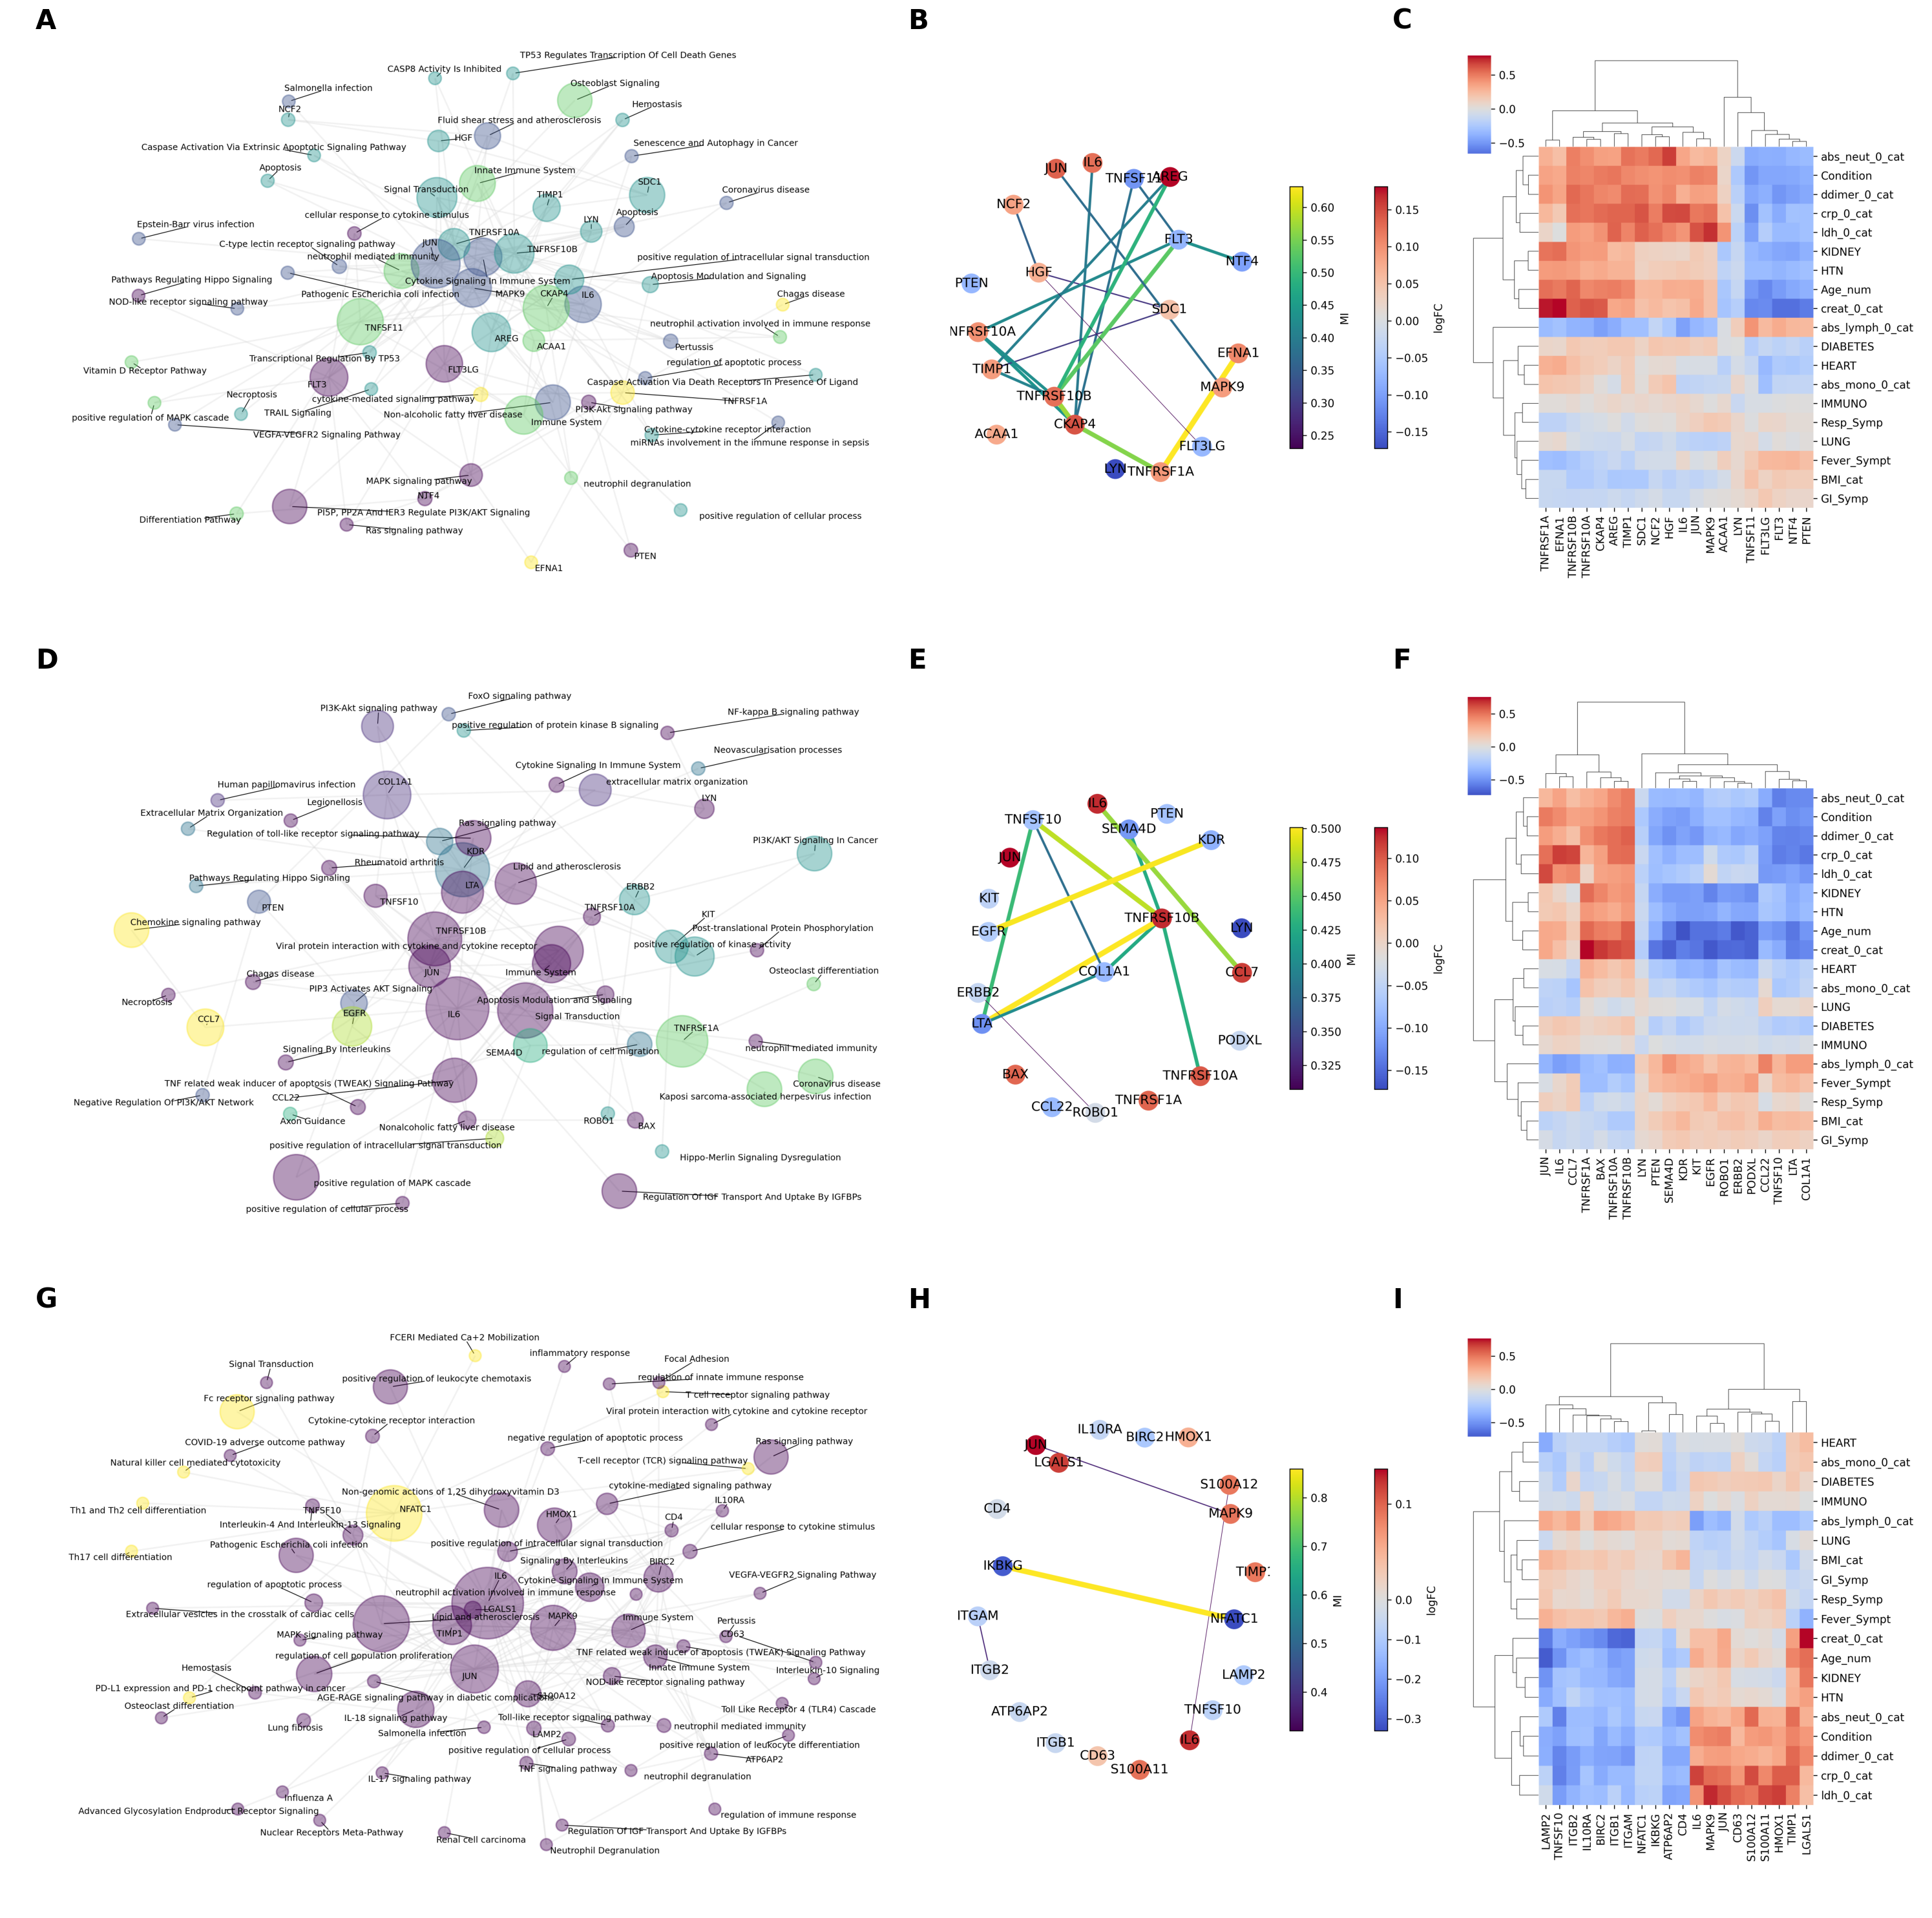

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images
image1 = mpimg.imread('graph_test.png')
# image2 = mpimg.imread('string_APNet_MGH_Mayo_SHAP.png')
image3 = mpimg.imread('APNet_MGH_Mayo_clinical_shap.png')
image2 = mpimg.imread('top_20_SHAP_MGH_Mayo_SJARACNe.png')
image4 = mpimg.imread('graph_test_Stan.png')
image5 = mpimg.imread('top_20_SHAP_MGH_Stanford_SJARACNe.png')
image6 = mpimg.imread('APNet_MGH_Stanford_clinical_shap.png')
image7 = mpimg.imread('graph_test_scMGH_v2.png')
image8 = mpimg.imread('top_20_SHAP_MGH_scMGH_SJARACNe.png')
image9 = mpimg.imread('APNet_MGH_scMGH_clinical_shap.png')

# Create a figure and a set of subplots with a 3x3 grid and adjusted width ratios
fig, axs = plt.subplots(3, 3, figsize=(30, 30), gridspec_kw={'width_ratios': [1.5, 0.8, 0.75]})

# Display images in the subplots
images = [image1, image2, image3, image4, image5, image6, image7, image8, image9]
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.axis('off')  # Hide the axis

# Add labels manually
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
label_positions = [
    (0.02, 0.98), (0.47, 0.98), (0.72, 0.98),
    (0.02, 0.65), (0.47, 0.65), (0.72, 0.65),
    (0.02, 0.32), (0.47, 0.32), (0.72, 0.32)
]
for label, pos in zip(labels, label_positions):
    fig.text(pos[0], pos[1], label, size=30, weight='bold', ha='left')

# Show the plot
plt.tight_layout()
plt.savefig('Figure_3.png', format='png', dpi=300)
plt.show()

## Figure 5

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
project_folder = "APNet_input_data/MGH_Mayo_experiment"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
/content/drive/My Drive/APNet_input_data/MGH_Mayo_experiment


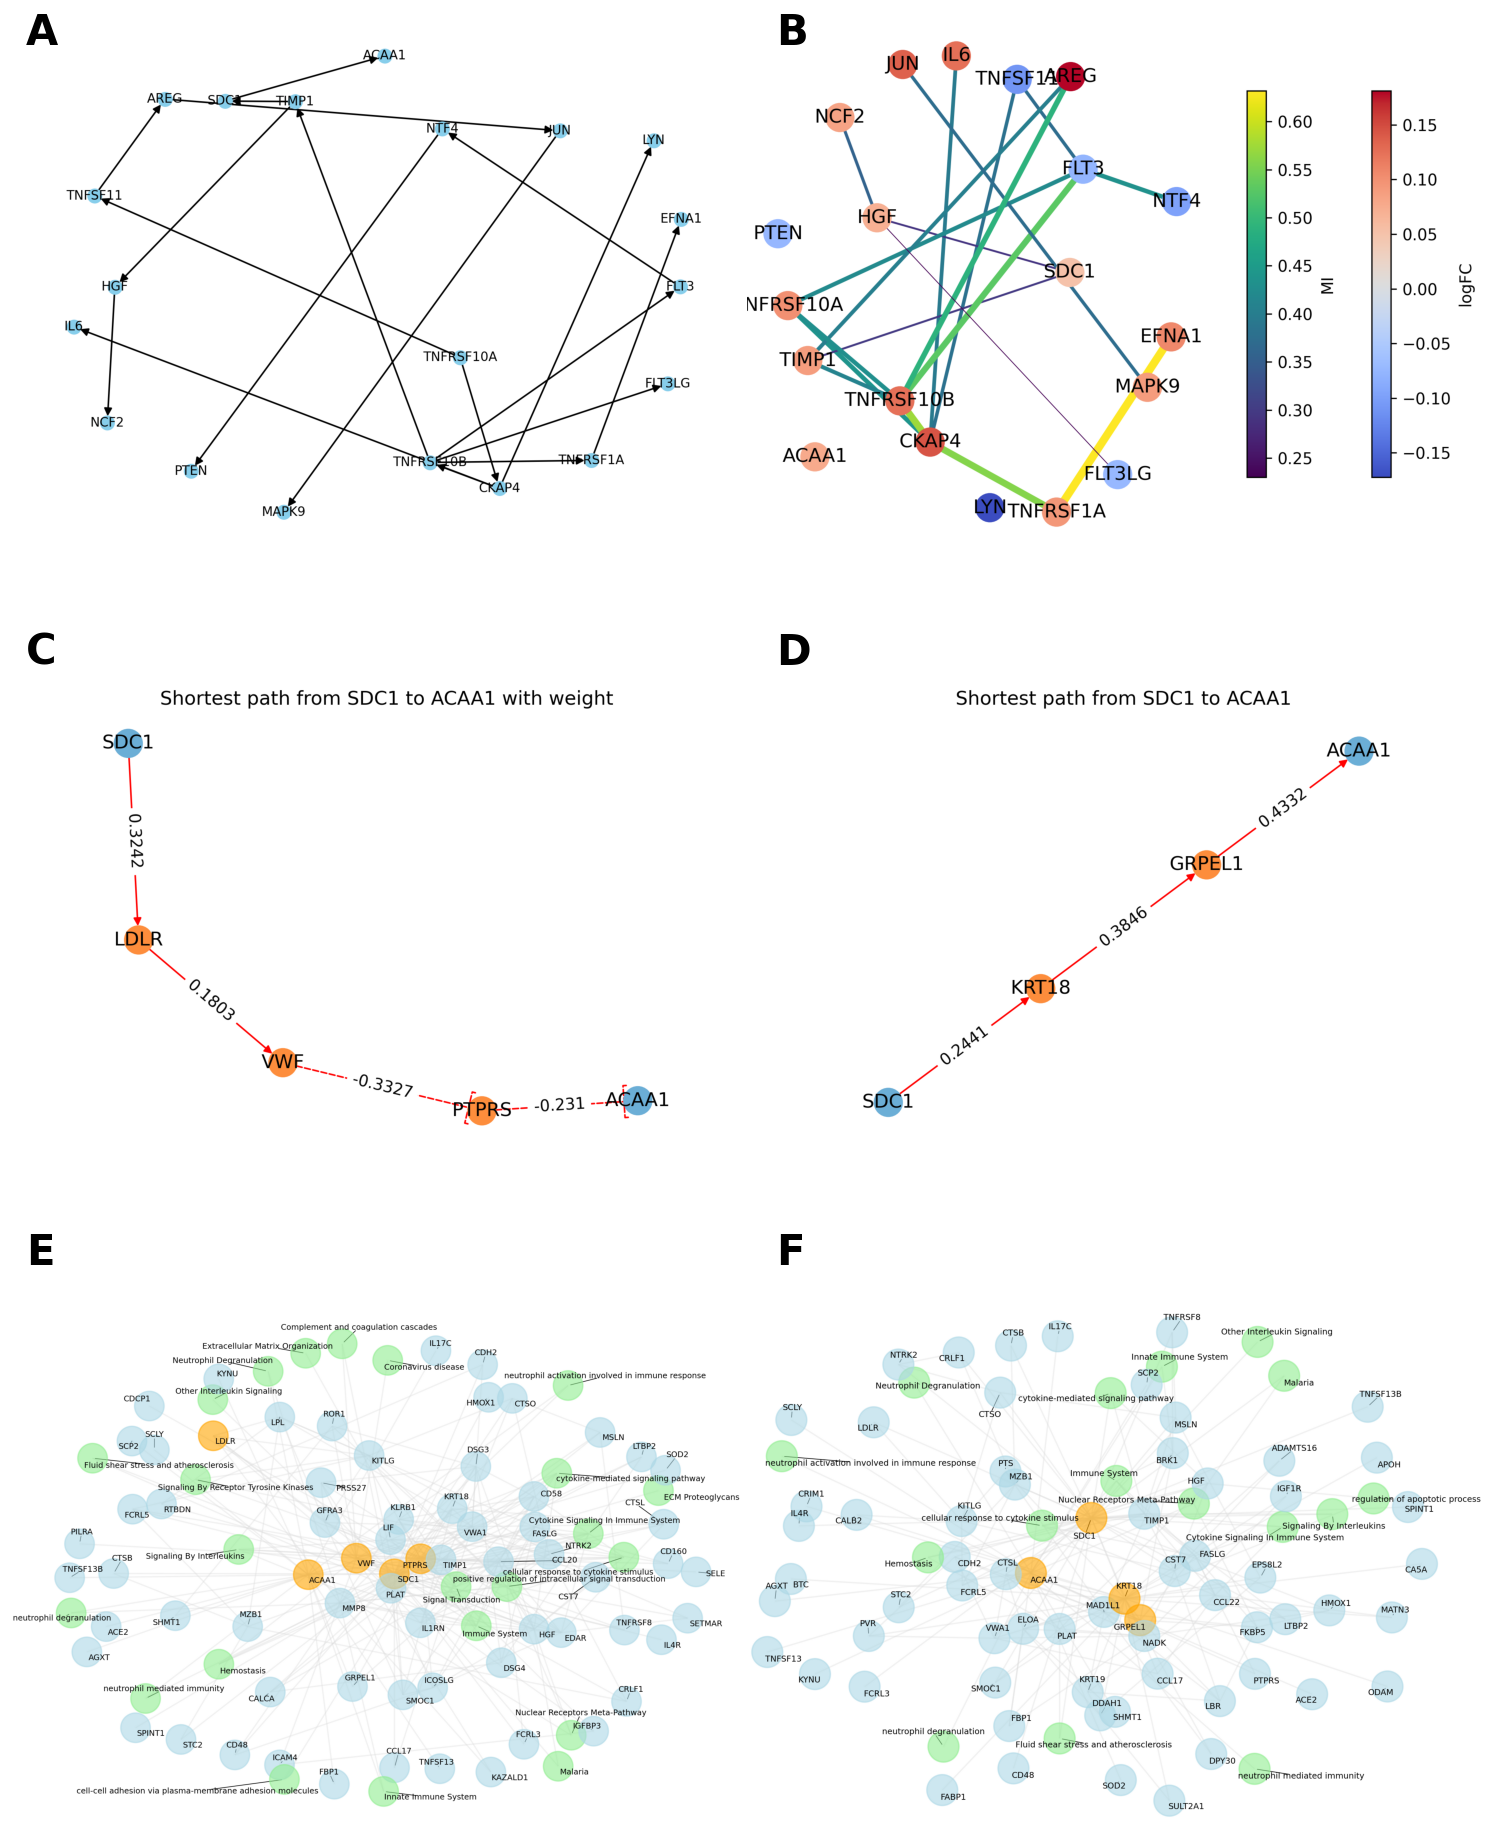

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images
image1 = mpimg.imread('Bayesian_APNet_MGH_Mayo.png')
image2 = mpimg.imread('top_20_SHAP_MGH_Mayo_SJARACNe.png')
image3 = mpimg.imread('SDC1_ACAA1_shortest_weight.png')
image4 = mpimg.imread('SDC1_ACAA1_shortest.png')
image5 = mpimg.imread('ACAA1_SDC1_extend_neighb.png')
image6 = mpimg.imread('ACAA1_SDC1_short_neighb.png')

# Create a figure and a set of subplots with adjusted width and height ratios
fig, axs = plt.subplots(3, 2, figsize=(15, 20), gridspec_kw={'width_ratios': [1.0, 1.0], 'height_ratios': [1, 1, 1]})

# Display images in the subplots
images = [image1, image2, image3, image4, image5, image6]
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.axis('off')  # Hide the axis

# Add labels manually
labels = ['A', 'B', 'C', 'D', 'E', 'F']
label_positions = [
    (0.02, 0.94), (0.52, 0.94),
    (0.02, 0.63), (0.52, 0.63),
    (0.02, 0.33), (0.52, 0.33)
]
for label, pos in zip(labels, label_positions):
    fig.text(pos[0], pos[1], label, size=30, weight='bold', ha='left')

# Adjust layout to reduce white space
plt.tight_layout(pad=1.0, h_pad=0.2, w_pad=0.2)
plt.savefig('Figure_5.png', format='png', dpi=300)
plt.show()